# 1\. Load dependency

In [46]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az
import pymc as pm
import pickle
import seaborn as sns
from tqdm import tqdm
import time
from warnings import filterwarnings
import contextily as cx
import pickle
filterwarnings('ignore')
pd.set_option('display.max_row', 100)

In [47]:
#####
wintering_prefix = 'wintering_model_level_3_May16'
breeding_prefix = 'breeding_model_level_3_May16'
input_final_df_prefix='final_df_model_level_3_May16'
SAMPLE_SIZE=1000
SAMPLE_CHAINS=2
SAMPLE_CORES=2
TUNES=1000


# 2\. Load data

In [48]:
data=pd.read_csv('./8531.csv')
data.shape

(71963, 506)

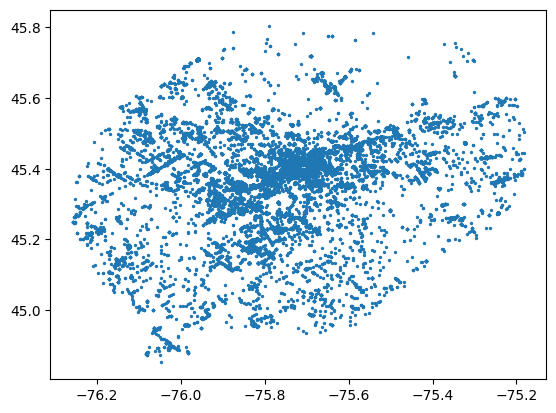

In [49]:
plt.scatter(data.longitude, data.latitude, s=2)
# ax =plt.gca()
# cx.add_basemap(ax, crs='EPSG:4326')
plt.show()

In [50]:
data.latitude.mean(), data.longitude.mean()

(45.35012631018301, -75.77214829329655)

In [51]:
data[data.urban_areas>0].shape, data[data.urban_areas==0].shape


((61639, 506), (10324, 506))

In [52]:
pm.__version__

'5.3.1'

# 3\. Load taxonomy data and filter species list

In [53]:
#### read taxonomy data
ebird = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/ebird_taxonomy/eBird_Taxonomy_v2021.csv')
avonet_raw = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/AVONET/AVONET_Raw_Data.csv')
migration = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/AVONET/AVONET1_BirdLife.csv')
taxon = ebird[['PRIMARY_COM_NAME','SCI_NAME','ORDER1','FAMILY']].drop_duplicates().rename(columns={'SCI_NAME':'Species2_eBird'}).merge(
    avonet_raw[['Species1_BirdLife','Species2_eBird']].drop_duplicates(),
    on='Species2_eBird', how='left'
    ).merge(
    migration[['Species1','Migration']].rename(columns={'Species1':'Species1_BirdLife'}),
    on='Species1_BirdLife', how='left'
    )
taxon = taxon[taxon['Migration']>1]


In [54]:
sp_list = list(data.columns)[list(data.columns).index('entropy')+1:]
sp_list = set(taxon.PRIMARY_COM_NAME.dropna().unique()) & set(sp_list)
sp_list = list(sp_list)
len(sp_list)

278

In [55]:
data[sp_list] = np.where(data[sp_list].fillna(0)>0,1,0)


In [56]:
### sorted sp list
sp_list = [i[0] for i in sorted(data[sp_list].sum().items(), key=lambda x:-x[1])]


# 4\. Filter input data by quality, demography, and migration type

In [57]:
def classify_mig_type(sub):
    
    spring_range = list(np.arange(60,152))
    summer_range = list(np.arange(152,245))
    fall_range = list(np.arange(245,337))
    winter_range = list(np.arange(1,60)) + list(np.arange(337,366))
    
    spring_occ = sub[sub.DOY.isin(spring_range)]['occ'].mean()
    summer_occ = sub[sub.DOY.isin(summer_range)]['occ'].mean()
    fall_occ = sub[sub.DOY.isin(fall_range)]['occ'].mean()
    winter_occ = sub[sub.DOY.isin(winter_range)]['occ'].mean()
    
    
    ###
    flag_list = []
    
    ### passgenger?
    if (spring_occ > winter_occ*2) & (fall_occ > winter_occ*2) & \
            (spring_occ > summer_occ*2) & (fall_occ > summer_occ*2):
        flag_list.append('passenger')
    
    if (winter_occ > summer_occ*2) & (winter_occ > spring_occ) & (winter_occ > fall_occ):
        flag_list.append('wintering')
    
    if (summer_occ > winter_occ*2) & (summer_occ > spring_occ) & (summer_occ > fall_occ):
        flag_list.append('breeding')
    
    return flag_list
        

In [58]:
## calculate cropland
data['cropland'] = data[['cropland_rainfed','cropland_irrigated_post_flooding','mosaic_cropland']].fillna(0).sum(axis=1).values



In [59]:
def assign_spatial_temporal_grid(sub):
    '''
        Spatial-temporal-urban-cropland subsampling. Five dimention. Booooom!
    '''
    lon_array = np.arange(sub.longitude.min(), sub.longitude.max(), 0.01)
    lat_array =  np.arange(sub.latitude.min(), sub.latitude.max(), 0.01)
    doy_array =  np.arange(sub.DOY.min(), sub.DOY.max(), 1)
    sub['lon_lat_doy_urban_crop_grid'] = [str(i)+'_'+str(j)+'_'+str(k) for i,j,k in zip(np.digitize(sub.longitude, lon_array),
                            np.digitize(sub.latitude, lat_array),
                            np.digitize(sub.DOY, doy_array)
                               )]
    
    return sub


def down_sample(new_sub, samples_each_class=500):
    '''
        If the sample size is still too large -- subsample
    '''
    
    spring_range = list(np.arange(60,152)) + list(range(40,60)) + list(range(152,172))
    summer_range = list(np.arange(152,245)) 
    fall_range = list(np.arange(245,337)) + list(range(225,245)) + list(range(337,357))
    winter_range = list(np.arange(1,60)) + list(np.arange(337,366))
    
    occ_new_sub = new_sub[new_sub.occ==0]
    
    def get_sample_by_seasons(df_, samples_each_class):
        spring_df = df_[df_.DOY.isin(spring_range)]
        fall_df = df_[df_.DOY.isin(fall_range)]
        non_migrating_df = df_[(~df_.DOY.isin(spring_df)) & (~df_.DOY.isin(fall_range))]
        
        sample_size = samples_each_class//3
        
        def get_sample(df,sample_size):
            if len(df)>sample_size:
                df = df.sample(sample_size, replace=False) ### if data is abundant, first sample expert's checklist
            else: #.iloc[:samples_each_class,:].sort_values(by='obsvr_species_count', ascending=False)
                pass #df = df.sample(sample_size, replace=True)
            return df
        
        new_df_ = pd.concat(
            [get_sample(spring_df, sample_size),
            get_sample(fall_df, sample_size),
            get_sample(non_migrating_df, sample_size)],
            axis=0
        ).reset_index(drop=True)
        
        return new_df_
    
    occ_new_sub = get_sample_by_seasons(new_sub[new_sub.occ==0], samples_each_class)
    non_occ_new_sub = get_sample_by_seasons(new_sub[new_sub.occ>0], samples_each_class)
    return pd.concat([occ_new_sub, non_occ_new_sub], axis=0).reset_index(drop=True)




In [60]:
def get_ml_score(X, y):
    ## can i use DOY, urban, cropland, duration to predict occ?
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score, precision_score, accuracy_score,make_scorer
    
    model = RandomForestClassifier(random_state=42,class_weight='balanced')
    scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score))
    return np.nanmean(scores)

In [69]:
#### pre-process data: filter species, subsampling
final_list = []
for sp in tqdm(sp_list):
    sp_order = taxon[taxon['PRIMARY_COM_NAME']==sp]['ORDER1'].values[0]
    sub = data[['DOY','year','obsvr_species_count','longitude','latitude','urban_areas','cropland','duration_minutes',sp]]
    sub = sub[(sub.obsvr_species_count>sorted(sub.obsvr_species_count)[int(len(sub)*0.05)]) &\
        (sub.obsvr_species_count<sorted(sub.obsvr_species_count)[int(len(sub)*0.95)])] #### remove outlier birder with extreme bird species count
    sub['Order'] = sp_order
    sub[sp] = sub[sp].fillna(0)
    sub=sub.dropna().rename(columns={sp:'occ'})
    sub['occ'] = np.where(sub['occ']>0,1,0)
    sub['sp'] = sp
    
    ### filtering
    ### only take summer breeding indiv
    flag_list = classify_mig_type(sub)
    if len(flag_list)>1 or len(flag_list)==0:
        continue
    else:
        flag=flag_list[0]
        
    #### filtering for each year
    sp_df_list = []
    for year in sorted(sub.year.unique()):
        ### filtering
        subsub=sub[sub.year==year]

        ### resample    
        ### subsample
        subsub = assign_spatial_temporal_grid(subsub)
        subsub = subsub.sample(frac=1, replace=False).groupby('lon_lat_doy_urban_crop_grid').first()
        
        if subsub[subsub.occ>0].shape[0]<100: ### after subsampling, if less than 100 observations, skip
            continue
        if len(subsub[(subsub.urban_areas>0.05) & (subsub.occ>0)])<30:
            continue
        if len(subsub[(subsub.cropland>0.05) & (subsub.occ>0)])<30:
            continue
        if len(subsub[(subsub.urban_areas<=0.05) & (subsub.cropland<=0.05) & (subsub.occ>0)])<30:
            continue
            
        if len(subsub)>1000: #.sort_values(by='obsvr_species_count',ascending=False)
            subsub = down_sample(subsub, samples_each_class=500) 
            
        subsub['migration_type'] = flag
        
        #### if unique DOY<200: continue
        if subsub.DOY.unique().shape[0]<200:
            continue

        #### ml score
        x_names = ['DOY','urban_areas','cropland','duration_minutes']
        ml_score = get_ml_score(subsub[x_names], subsub['occ'])
        
        if ml_score>0.6:
            sp_df_list.append(subsub)
        else:
            continue
        
        print(sp, year, 'Total: ',subsub.shape, 'Unique DOY: ', subsub.DOY.unique().shape[0],
              'Occ: ', subsub[subsub.occ>0].shape, 
              'Occ_urban: ',subsub[(subsub.urban_areas>0.05) & (subsub.occ>0)].shape,
              'Occ_cropland: ', subsub[(subsub.cropland>0.05) & (subsub.occ>0)].shape,
              'Occ_nature: ', subsub[(subsub.urban_areas<=0.05) & (subsub.cropland<=0.05) & (subsub.occ>0)].shape,
              'ML_score: ',ml_score)
        
        
    if len(sp_df_list)==0:
        continue

    print(flag,end='..')
    print(f'{len(sp_df_list)} years samples',end='..')
    final_list.append(pd.concat(sp_df_list, axis=0).reset_index(drop=True))
    
    
print('total species: ',len(final_list))
final_df = pd.concat(final_list, axis=0).reset_index(drop=True)



  0%|          | 0/278 [00:00<?, ?it/s]

2011 appending
Song Sparrow 2011 Total:  (984, 12) Unique DOY:  303 Occ:  (486, 12) Occ_urban:  (330, 12) Occ_cropland:  (91, 12) Occ_nature:  (116, 12) ML_score:  0.688149914886292
2012 appending
Song Sparrow 2012 Total:  (977, 12) Unique DOY:  319 Occ:  (479, 12) Occ_urban:  (293, 12) Occ_cropland:  (98, 12) Occ_nature:  (141, 12) ML_score:  0.7097969165337586
2013 appending
Song Sparrow 2013 Total:  (996, 12) Unique DOY:  296 Occ:  (498, 12) Occ_urban:  (344, 12) Occ_cropland:  (108, 12) Occ_nature:  (113, 12) ML_score:  0.742030303030303
2014 appending
Song Sparrow 2014 Total:  (996, 12) Unique DOY:  309 Occ:  (498, 12) Occ_urban:  (341, 12) Occ_cropland:  (152, 12) Occ_nature:  (94, 12) ML_score:  0.762080808080808
2015 appending
Song Sparrow 2015 Total:  (996, 12) Unique DOY:  298 Occ:  (498, 12) Occ_urban:  (287, 12) Occ_cropland:  (153, 12) Occ_nature:  (150, 12) ML_score:  0.730979797979798
2016 appending
Song Sparrow 2016 Total:  (996, 12) Unique DOY:  303 Occ:  (498, 12) Occ

  1%|          | 2/278 [00:05<12:53,  2.80s/it]

2018 appending
Song Sparrow 2018 Total:  (996, 12) Unique DOY:  311 Occ:  (498, 12) Occ_urban:  (392, 12) Occ_cropland:  (140, 12) Occ_nature:  (74, 12) ML_score:  0.7400505050505051
breeding..8 years samples..2011 appending
American Robin 2011 Total:  (992, 12) Unique DOY:  314 Occ:  (494, 12) Occ_urban:  (355, 12) Occ_cropland:  (97, 12) Occ_nature:  (102, 12) ML_score:  0.6484475365903937
2012 appending
American Robin 2012 Total:  (996, 12) Unique DOY:  317 Occ:  (498, 12) Occ_urban:  (321, 12) Occ_cropland:  (123, 12) Occ_nature:  (123, 12) ML_score:  0.6616767676767676
2013 appending
American Robin 2013 Total:  (996, 12) Unique DOY:  296 Occ:  (498, 12) Occ_urban:  (359, 12) Occ_cropland:  (119, 12) Occ_nature:  (98, 12) ML_score:  0.6404747474747474
2014 appending
American Robin 2014 Total:  (996, 12) Unique DOY:  301 Occ:  (498, 12) Occ_urban:  (344, 12) Occ_cropland:  (158, 12) Occ_nature:  (90, 12) ML_score:  0.6052929292929293
2015 appending
American Robin 2015 Total:  (996, 

  3%|▎         | 7/278 [00:11<05:23,  1.19s/it]

2018 appending
American Robin 2018 Total:  (996, 12) Unique DOY:  309 Occ:  (498, 12) Occ_urban:  (376, 12) Occ_cropland:  (141, 12) Occ_nature:  (84, 12) ML_score:  0.6446767676767677
breeding..8 years samples..2011 appending
Red-winged Blackbird 2011 Total:  (939, 12) Unique DOY:  293 Occ:  (441, 12) Occ_urban:  (300, 12) Occ_cropland:  (89, 12) Occ_nature:  (112, 12) ML_score:  0.6943938258994438
2012 appending
Red-winged Blackbird 2012 Total:  (971, 12) Unique DOY:  310 Occ:  (473, 12) Occ_urban:  (310, 12) Occ_cropland:  (100, 12) Occ_nature:  (123, 12) ML_score:  0.7450695080706279
2013 appending
Red-winged Blackbird 2013 Total:  (996, 12) Unique DOY:  296 Occ:  (498, 12) Occ_urban:  (345, 12) Occ_cropland:  (103, 12) Occ_nature:  (121, 12) ML_score:  0.6274747474747475
2014 appending
Red-winged Blackbird 2014 Total:  (996, 12) Unique DOY:  298 Occ:  (498, 12) Occ_urban:  (332, 12) Occ_cropland:  (161, 12) Occ_nature:  (96, 12) ML_score:  0.7057171717171717
2015 appending
Red-win

  3%|▎         | 9/278 [00:21<10:52,  2.42s/it]

2018 appending
Common Grackle 2018 Total:  (996, 12) Unique DOY:  308 Occ:  (498, 12) Occ_urban:  (386, 12) Occ_cropland:  (137, 12) Occ_nature:  (82, 12) ML_score:  0.7066666666666666
breeding..8 years samples..2011 appending
Dark-eyed Junco 2011 Total:  (918, 12) Unique DOY:  320 Occ:  (420, 12) Occ_urban:  (281, 12) Occ_cropland:  (52, 12) Occ_nature:  (118, 12) ML_score:  0.7436637806637807
2012 appending
Dark-eyed Junco 2012 Total:  (865, 12) Unique DOY:  303 Occ:  (367, 12) Occ_urban:  (233, 12) Occ_cropland:  (83, 12) Occ_nature:  (98, 12) ML_score:  0.6878801192225851
2013 appending
Dark-eyed Junco 2013 Total:  (996, 12) Unique DOY:  288 Occ:  (498, 12) Occ_urban:  (359, 12) Occ_cropland:  (89, 12) Occ_nature:  (105, 12) ML_score:  0.7107777777777778
2014 appending
Dark-eyed Junco 2014 Total:  (996, 12) Unique DOY:  293 Occ:  (498, 12) Occ_urban:  (335, 12) Occ_cropland:  (149, 12) Occ_nature:  (106, 12) ML_score:  0.6957979797979799
2015 appending
Dark-eyed Junco 2015 Total:  

  4%|▎         | 10/278 [00:25<12:41,  2.84s/it]

2018 appending
Dark-eyed Junco 2018 Total:  (996, 12) Unique DOY:  310 Occ:  (498, 12) Occ_urban:  (370, 12) Occ_cropland:  (148, 12) Occ_nature:  (86, 12) ML_score:  0.7186666666666666
wintering..8 years samples..2011 appending
Chipping Sparrow 2011 Total:  (852, 12) Unique DOY:  283 Occ:  (354, 12) Occ_urban:  (232, 12) Occ_cropland:  (77, 12) Occ_nature:  (87, 12) ML_score:  0.8152416722557566
2012 appending
Chipping Sparrow 2012 Total:  (752, 12) Unique DOY:  293 Occ:  (254, 12) Occ_urban:  (158, 12) Occ_cropland:  (47, 12) Occ_nature:  (73, 12) ML_score:  0.7545341651812241
2013 appending
Chipping Sparrow 2013 Total:  (996, 12) Unique DOY:  275 Occ:  (498, 12) Occ_urban:  (338, 12) Occ_cropland:  (112, 12) Occ_nature:  (111, 12) ML_score:  0.7178080808080807
2014 appending
Chipping Sparrow 2014 Total:  (996, 12) Unique DOY:  280 Occ:  (498, 12) Occ_urban:  (350, 12) Occ_cropland:  (168, 12) Occ_nature:  (93, 12) ML_score:  0.7479090909090909
2015 appending
Chipping Sparrow 2015 To

  5%|▍         | 13/278 [00:29<09:37,  2.18s/it]

2018 appending
Chipping Sparrow 2018 Total:  (996, 12) Unique DOY:  290 Occ:  (498, 12) Occ_urban:  (375, 12) Occ_cropland:  (146, 12) Occ_nature:  (93, 12) ML_score:  0.744959595959596
breeding..8 years samples..2011 appending
White-throated Sparrow 2011 Total:  (861, 12) Unique DOY:  302 Occ:  (363, 12) Occ_urban:  (241, 12) Occ_cropland:  (65, 12) Occ_nature:  (88, 12) ML_score:  0.7371891517918915
2012 appending
White-throated Sparrow 2012 Total:  (869, 12) Unique DOY:  313 Occ:  (371, 12) Occ_urban:  (222, 12) Occ_cropland:  (72, 12) Occ_nature:  (115, 12) ML_score:  0.7160679770679771
2013 appending
White-throated Sparrow 2013 Total:  (996, 12) Unique DOY:  276 Occ:  (498, 12) Occ_urban:  (375, 12) Occ_cropland:  (100, 12) Occ_nature:  (89, 12) ML_score:  0.6806969696969697
2014 appending
White-throated Sparrow 2014 Total:  (996, 12) Unique DOY:  283 Occ:  (498, 12) Occ_urban:  (353, 12) Occ_cropland:  (166, 12) Occ_nature:  (74, 12) ML_score:  0.6867878787878788
2015 appending
W

  5%|▌         | 14/278 [00:34<11:20,  2.58s/it]

2018 appending
White-throated Sparrow 2018 Total:  (996, 12) Unique DOY:  296 Occ:  (498, 12) Occ_urban:  (391, 12) Occ_cropland:  (132, 12) Occ_nature:  (80, 12) ML_score:  0.6928787878787878
breeding..8 years samples..2011 appending
Northern Flicker 2011 Total:  (807, 12) Unique DOY:  282 Occ:  (309, 12) Occ_urban:  (197, 12) Occ_cropland:  (68, 12) Occ_nature:  (84, 12) ML_score:  0.8252657083794048
2012 appending
Northern Flicker 2012 Total:  (785, 12) Unique DOY:  280 Occ:  (287, 12) Occ_urban:  (194, 12) Occ_cropland:  (65, 12) Occ_nature:  (66, 12) ML_score:  0.6086284991475553
2013 appending
Northern Flicker 2013 Total:  (996, 12) Unique DOY:  275 Occ:  (498, 12) Occ_urban:  (363, 12) Occ_cropland:  (89, 12) Occ_nature:  (105, 12) ML_score:  0.7167474747474747
2014 appending
Northern Flicker 2014 Total:  (996, 12) Unique DOY:  293 Occ:  (498, 12) Occ_urban:  (364, 12) Occ_cropland:  (167, 12) Occ_nature:  (77, 12) ML_score:  0.6936060606060607
2015 appending
Northern Flicker 20

  5%|▌         | 15/278 [00:38<12:47,  2.92s/it]

2018 appending
Northern Flicker 2018 Total:  (996, 12) Unique DOY:  287 Occ:  (498, 12) Occ_urban:  (379, 12) Occ_cropland:  (128, 12) Occ_nature:  (101, 12) ML_score:  0.723010101010101
breeding..8 years samples..2011 appending
Red-eyed Vireo 2011 Total:  (830, 12) Unique DOY:  272 Occ:  (332, 12) Occ_urban:  (222, 12) Occ_cropland:  (58, 12) Occ_nature:  (88, 12) ML_score:  0.8855478667269712
2012 appending
Red-eyed Vireo 2012 Total:  (698, 12) Unique DOY:  270 Occ:  (200, 12) Occ_urban:  (126, 12) Occ_cropland:  (52, 12) Occ_nature:  (54, 12) ML_score:  0.7193484848484848
2013 appending
Red-eyed Vireo 2013 Total:  (909, 12) Unique DOY:  277 Occ:  (411, 12) Occ_urban:  (291, 12) Occ_cropland:  (94, 12) Occ_nature:  (88, 12) ML_score:  0.7297902801152875
2014 appending
Red-eyed Vireo 2014 Total:  (871, 12) Unique DOY:  270 Occ:  (373, 12) Occ_urban:  (256, 12) Occ_cropland:  (108, 12) Occ_nature:  (72, 12) ML_score:  0.7811381381381383
2015 appending
Red-eyed Vireo 2015 Total:  (924, 

  6%|▋         | 18/278 [00:42<09:18,  2.15s/it]

2018 appending
Red-eyed Vireo 2018 Total:  (837, 12) Unique DOY:  282 Occ:  (339, 12) Occ_urban:  (244, 12) Occ_cropland:  (96, 12) Occ_nature:  (77, 12) ML_score:  0.7519128067328243
breeding..8 years samples..2012 appending
Yellow Warbler 2012 Total:  (704, 12) Unique DOY:  267 Occ:  (206, 12) Occ_urban:  (130, 12) Occ_cropland:  (55, 12) Occ_nature:  (57, 12) ML_score:  0.7982449934888959
2013 appending
Yellow Warbler 2013 Total:  (964, 12) Unique DOY:  286 Occ:  (466, 12) Occ_urban:  (317, 12) Occ_cropland:  (113, 12) Occ_nature:  (105, 12) ML_score:  0.8328767149879024
2014 appending
Yellow Warbler 2014 Total:  (987, 12) Unique DOY:  274 Occ:  (489, 12) Occ_urban:  (345, 12) Occ_cropland:  (155, 12) Occ_nature:  (79, 12) ML_score:  0.8371015137701441
2015 appending
Yellow Warbler 2015 Total:  (996, 12) Unique DOY:  290 Occ:  (498, 12) Occ_urban:  (296, 12) Occ_cropland:  (150, 12) Occ_nature:  (139, 12) ML_score:  0.8183434343434344
2016 appending
Yellow Warbler 2016 Total:  (874,

  7%|▋         | 19/278 [00:45<10:22,  2.40s/it]

2018 appending
Yellow Warbler 2018 Total:  (996, 12) Unique DOY:  284 Occ:  (498, 12) Occ_urban:  (387, 12) Occ_cropland:  (123, 12) Occ_nature:  (94, 12) ML_score:  0.8361919191919192
breeding..7 years samples..2012 appending
Eastern Phoebe 2012 Total:  (712, 12) Unique DOY:  275 Occ:  (214, 12) Occ_urban:  (143, 12) Occ_cropland:  (46, 12) Occ_nature:  (57, 12) ML_score:  0.6144500151011779
2013 appending
Eastern Phoebe 2013 Total:  (961, 12) Unique DOY:  264 Occ:  (463, 12) Occ_urban:  (340, 12) Occ_cropland:  (86, 12) Occ_nature:  (92, 12) ML_score:  0.6977204301075269
2014 appending
Eastern Phoebe 2014 Total:  (996, 12) Unique DOY:  288 Occ:  (498, 12) Occ_urban:  (344, 12) Occ_cropland:  (138, 12) Occ_nature:  (95, 12) ML_score:  0.7088383838383837
2015 appending
Eastern Phoebe 2015 Total:  (996, 12) Unique DOY:  280 Occ:  (498, 12) Occ_urban:  (297, 12) Occ_cropland:  (138, 12) Occ_nature:  (137, 12) ML_score:  0.6496666666666666
2016 appending
Eastern Phoebe 2016 Total:  (996, 

  7%|▋         | 20/278 [00:49<11:40,  2.72s/it]

2018 appending
Eastern Phoebe 2018 Total:  (996, 12) Unique DOY:  290 Occ:  (498, 12) Occ_urban:  (388, 12) Occ_cropland:  (136, 12) Occ_nature:  (84, 12) ML_score:  0.6775252525252526
breeding..7 years samples..2012 appending
Tree Swallow 2012 Total:  (730, 12) Unique DOY:  274 Occ:  (232, 12) Occ_urban:  (164, 12) Occ_cropland:  (64, 12) Occ_nature:  (43, 12) ML_score:  0.7242919668470085
2013 appending
Tree Swallow 2013 Total:  (921, 12) Unique DOY:  290 Occ:  (423, 12) Occ_urban:  (300, 12) Occ_cropland:  (78, 12) Occ_nature:  (97, 12) ML_score:  0.7201594092182327
2014 appending
Tree Swallow 2014 Total:  (972, 12) Unique DOY:  285 Occ:  (474, 12) Occ_urban:  (333, 12) Occ_cropland:  (147, 12) Occ_nature:  (95, 12) ML_score:  0.7937670659563156
2015 appending
Tree Swallow 2015 Total:  (996, 12) Unique DOY:  282 Occ:  (498, 12) Occ_urban:  (291, 12) Occ_cropland:  (147, 12) Occ_nature:  (145, 12) ML_score:  0.7418484848484849
2016 appending
Tree Swallow 2016 Total:  (996, 12) Unique

  8%|▊         | 21/278 [00:53<12:49,  3.00s/it]

2018 appending
Tree Swallow 2018 Total:  (996, 12) Unique DOY:  295 Occ:  (498, 12) Occ_urban:  (393, 12) Occ_cropland:  (126, 12) Occ_nature:  (85, 12) ML_score:  0.766040404040404
breeding..7 years samples..2013 appending
Gray Catbird 2013 Total:  (900, 12) Unique DOY:  273 Occ:  (402, 12) Occ_urban:  (273, 12) Occ_cropland:  (83, 12) Occ_nature:  (97, 12) ML_score:  0.7176175645342312
2014 appending
Gray Catbird 2014 Total:  (932, 12) Unique DOY:  272 Occ:  (434, 12) Occ_urban:  (319, 12) Occ_cropland:  (142, 12) Occ_nature:  (63, 12) ML_score:  0.7524280171401263
2015 appending
Gray Catbird 2015 Total:  (954, 12) Unique DOY:  268 Occ:  (456, 12) Occ_urban:  (255, 12) Occ_cropland:  (133, 12) Occ_nature:  (138, 12) ML_score:  0.738020800455583
2016 appending
Gray Catbird 2016 Total:  (839, 12) Unique DOY:  274 Occ:  (341, 12) Occ_urban:  (255, 12) Occ_cropland:  (99, 12) Occ_nature:  (75, 12) ML_score:  0.7127368053940945
2017 appending
Gray Catbird 2017 Total:  (831, 12) Unique DOY

  8%|▊         | 22/278 [00:57<13:20,  3.13s/it]

2018 appending
Gray Catbird 2018 Total:  (891, 12) Unique DOY:  283 Occ:  (393, 12) Occ_urban:  (295, 12) Occ_cropland:  (90, 12) Occ_nature:  (80, 12) ML_score:  0.6970739626056082
breeding..6 years samples..2011 appending
Common Yellowthroat 2011 Total:  (762, 12) Unique DOY:  268 Occ:  (264, 12) Occ_urban:  (190, 12) Occ_cropland:  (57, 12) Occ_nature:  (51, 12) ML_score:  0.8604244623301227
2013 appending
Common Yellowthroat 2013 Total:  (905, 12) Unique DOY:  259 Occ:  (407, 12) Occ_urban:  (275, 12) Occ_cropland:  (94, 12) Occ_nature:  (98, 12) ML_score:  0.6885815061180914
2014 appending
Common Yellowthroat 2014 Total:  (894, 12) Unique DOY:  278 Occ:  (396, 12) Occ_urban:  (270, 12) Occ_cropland:  (115, 12) Occ_nature:  (84, 12) ML_score:  0.7266217874952051
2015 appending
Common Yellowthroat 2015 Total:  (913, 12) Unique DOY:  278 Occ:  (415, 12) Occ_urban:  (238, 12) Occ_cropland:  (117, 12) Occ_nature:  (122, 12) ML_score:  0.7154491907022027
2016 appending
Common Yellowthro

  9%|▉         | 26/278 [01:01<07:48,  1.86s/it]

2018 appending
Common Yellowthroat 2018 Total:  (872, 12) Unique DOY:  273 Occ:  (374, 12) Occ_urban:  (277, 12) Occ_cropland:  (96, 12) Occ_nature:  (78, 12) ML_score:  0.7336612066612066
breeding..7 years samples..2012 appending
American Tree Sparrow 2012 Total:  (843, 12) Unique DOY:  283 Occ:  (345, 12) Occ_urban:  (218, 12) Occ_cropland:  (87, 12) Occ_nature:  (91, 12) ML_score:  0.7893530961791831
2013 appending
American Tree Sparrow 2013 Total:  (985, 12) Unique DOY:  278 Occ:  (487, 12) Occ_urban:  (340, 12) Occ_cropland:  (100, 12) Occ_nature:  (103, 12) ML_score:  0.7695725591704973
2014 appending
American Tree Sparrow 2014 Total:  (996, 12) Unique DOY:  296 Occ:  (498, 12) Occ_urban:  (342, 12) Occ_cropland:  (154, 12) Occ_nature:  (98, 12) ML_score:  0.7960202020202021
2015 appending
American Tree Sparrow 2015 Total:  (996, 12) Unique DOY:  301 Occ:  (498, 12) Occ_urban:  (361, 12) Occ_cropland:  (165, 12) Occ_nature:  (75, 12) ML_score:  0.7938787878787877
2016 appending
A

 10%|▉         | 27/278 [01:05<09:25,  2.25s/it]

2018 appending
American Tree Sparrow 2018 Total:  (996, 12) Unique DOY:  311 Occ:  (498, 12) Occ_urban:  (386, 12) Occ_cropland:  (118, 12) Occ_nature:  (83, 12) ML_score:  0.777989898989899
wintering..7 years samples..2012 appending
Common Goldeneye 2012 Total:  (838, 12) Unique DOY:  278 Occ:  (340, 12) Occ_urban:  (220, 12) Occ_cropland:  (92, 12) Occ_nature:  (88, 12) ML_score:  0.7978193701723113
2013 appending
Common Goldeneye 2013 Total:  (941, 12) Unique DOY:  280 Occ:  (443, 12) Occ_urban:  (319, 12) Occ_cropland:  (79, 12) Occ_nature:  (94, 12) ML_score:  0.7551807399841107
2014 appending
Common Goldeneye 2014 Total:  (996, 12) Unique DOY:  301 Occ:  (498, 12) Occ_urban:  (344, 12) Occ_cropland:  (119, 12) Occ_nature:  (106, 12) ML_score:  0.7508686868686867
2015 appending
Common Goldeneye 2015 Total:  (996, 12) Unique DOY:  305 Occ:  (498, 12) Occ_urban:  (330, 12) Occ_cropland:  (165, 12) Occ_nature:  (106, 12) ML_score:  0.7416565656565657
2016 appending
Common Goldeneye 2

 10%|█         | 28/278 [01:08<10:30,  2.52s/it]

2018 appending
Common Goldeneye 2018 Total:  (996, 12) Unique DOY:  313 Occ:  (498, 12) Occ_urban:  (387, 12) Occ_cropland:  (122, 12) Occ_nature:  (67, 12) ML_score:  0.6999090909090908
wintering..7 years samples..2013 appending
American Redstart 2013 Total:  (926, 12) Unique DOY:  277 Occ:  (428, 12) Occ_urban:  (298, 12) Occ_cropland:  (101, 12) Occ_nature:  (88, 12) ML_score:  0.7986065027843413
2014 appending
American Redstart 2014 Total:  (934, 12) Unique DOY:  277 Occ:  (436, 12) Occ_urban:  (325, 12) Occ_cropland:  (149, 12) Occ_nature:  (58, 12) ML_score:  0.7784541971438523
2015 appending
American Redstart 2015 Total:  (957, 12) Unique DOY:  266 Occ:  (459, 12) Occ_urban:  (286, 12) Occ_cropland:  (129, 12) Occ_nature:  (120, 12) ML_score:  0.7662294468816208
2016 appending
American Redstart 2016 Total:  (834, 12) Unique DOY:  277 Occ:  (336, 12) Occ_urban:  (251, 12) Occ_cropland:  (86, 12) Occ_nature:  (68, 12) ML_score:  0.7686151772332632
2017 appending
American Redstart 

 10%|█         | 29/278 [01:11<10:54,  2.63s/it]

2018 appending
American Redstart 2018 Total:  (894, 12) Unique DOY:  282 Occ:  (396, 12) Occ_urban:  (298, 12) Occ_cropland:  (90, 12) Occ_nature:  (82, 12) ML_score:  0.760985359928398
breeding..6 years samples..2012 appending
Turkey Vulture 2012 Total:  (672, 12) Unique DOY:  269 Occ:  (174, 12) Occ_urban:  (118, 12) Occ_cropland:  (41, 12) Occ_nature:  (42, 12) ML_score:  0.6355626856803328
2013 appending
Turkey Vulture 2013 Total:  (899, 12) Unique DOY:  276 Occ:  (401, 12) Occ_urban:  (291, 12) Occ_cropland:  (83, 12) Occ_nature:  (84, 12) ML_score:  0.6975036475869809
2014 appending
Turkey Vulture 2014 Total:  (988, 12) Unique DOY:  282 Occ:  (490, 12) Occ_urban:  (320, 12) Occ_cropland:  (143, 12) Occ_nature:  (109, 12) ML_score:  0.660936507936508
2015 appending
Turkey Vulture 2015 Total:  (996, 12) Unique DOY:  274 Occ:  (498, 12) Occ_urban:  (310, 12) Occ_cropland:  (133, 12) Occ_nature:  (139, 12) ML_score:  0.6685959595959595
2016 appending
Turkey Vulture 2016 Total:  (996,

 11%|█         | 31/278 [01:15<09:41,  2.36s/it]

2018 appending
Turkey Vulture 2018 Total:  (996, 12) Unique DOY:  287 Occ:  (498, 12) Occ_urban:  (393, 12) Occ_cropland:  (135, 12) Occ_nature:  (80, 12) ML_score:  0.6766666666666666
breeding..7 years samples..2011 appending
Great Crested Flycatcher 2011 Total:  (754, 12) Unique DOY:  266 Occ:  (256, 12) Occ_urban:  (166, 12) Occ_cropland:  (57, 12) Occ_nature:  (60, 12) ML_score:  0.864247817541935
2012 appending
Great Crested Flycatcher 2012 Total:  (669, 12) Unique DOY:  270 Occ:  (171, 12) Occ_urban:  (116, 12) Occ_cropland:  (40, 12) Occ_nature:  (43, 12) ML_score:  0.6058300653594771
2013 appending
Great Crested Flycatcher 2013 Total:  (911, 12) Unique DOY:  273 Occ:  (413, 12) Occ_urban:  (279, 12) Occ_cropland:  (97, 12) Occ_nature:  (95, 12) ML_score:  0.7619222611065104
2014 appending
Great Crested Flycatcher 2014 Total:  (931, 12) Unique DOY:  276 Occ:  (433, 12) Occ_urban:  (301, 12) Occ_cropland:  (128, 12) Occ_nature:  (80, 12) ML_score:  0.8029734797858294
2015 appendi

 12%|█▏        | 32/278 [01:19<10:52,  2.65s/it]

2018 appending
Great Crested Flycatcher 2018 Total:  (887, 12) Unique DOY:  275 Occ:  (389, 12) Occ_urban:  (297, 12) Occ_cropland:  (107, 12) Occ_nature:  (77, 12) ML_score:  0.7419080919080919
breeding..8 years samples..2013 appending
Warbling Vireo 2013 Total:  (889, 12) Unique DOY:  270 Occ:  (391, 12) Occ_urban:  (240, 12) Occ_cropland:  (102, 12) Occ_nature:  (107, 12) ML_score:  0.7616264888416787
2014 appending
Warbling Vireo 2014 Total:  (927, 12) Unique DOY:  274 Occ:  (429, 12) Occ_urban:  (313, 12) Occ_cropland:  (110, 12) Occ_nature:  (73, 12) ML_score:  0.7963612043830921
2015 appending
Warbling Vireo 2015 Total:  (982, 12) Unique DOY:  278 Occ:  (484, 12) Occ_urban:  (298, 12) Occ_cropland:  (127, 12) Occ_nature:  (131, 12) ML_score:  0.7540787644486098
2016 appending
Warbling Vireo 2016 Total:  (841, 12) Unique DOY:  269 Occ:  (343, 12) Occ_urban:  (238, 12) Occ_cropland:  (101, 12) Occ_nature:  (89, 12) ML_score:  0.7733314474669973
2017 appending
Warbling Vireo 2017 T

 12%|█▏        | 34/278 [01:22<09:21,  2.30s/it]

2018 appending
Warbling Vireo 2018 Total:  (906, 12) Unique DOY:  277 Occ:  (408, 12) Occ_urban:  (318, 12) Occ_cropland:  (95, 12) Occ_nature:  (78, 12) ML_score:  0.6853866305329721
breeding..6 years samples..2013 appending
Killdeer 2013 Total:  (879, 12) Unique DOY:  271 Occ:  (381, 12) Occ_urban:  (287, 12) Occ_cropland:  (72, 12) Occ_nature:  (75, 12) ML_score:  0.7126690969848865
2014 appending
Killdeer 2014 Total:  (865, 12) Unique DOY:  271 Occ:  (367, 12) Occ_urban:  (247, 12) Occ_cropland:  (90, 12) Occ_nature:  (87, 12) ML_score:  0.7357372989427784
2015 appending
Killdeer 2015 Total:  (990, 12) Unique DOY:  286 Occ:  (492, 12) Occ_urban:  (294, 12) Occ_cropland:  (163, 12) Occ_nature:  (126, 12) ML_score:  0.6321966604823748
2017 appending
Killdeer 2017 Total:  (996, 12) Unique DOY:  278 Occ:  (498, 12) Occ_urban:  (375, 12) Occ_cropland:  (152, 12) Occ_nature:  (86, 12) ML_score:  0.6485858585858587


 13%|█▎        | 35/278 [01:26<10:38,  2.63s/it]

2018 appending
Killdeer 2018 Total:  (995, 12) Unique DOY:  294 Occ:  (497, 12) Occ_urban:  (363, 12) Occ_cropland:  (135, 12) Occ_nature:  (108, 12) ML_score:  0.6511717171717172
breeding..5 years samples..2012 appending
Common Merganser 2012 Total:  (834, 12) Unique DOY:  291 Occ:  (336, 12) Occ_urban:  (201, 12) Occ_cropland:  (88, 12) Occ_nature:  (95, 12) ML_score:  0.7992205727157439
2013 appending
Common Merganser 2013 Total:  (969, 12) Unique DOY:  276 Occ:  (471, 12) Occ_urban:  (333, 12) Occ_cropland:  (91, 12) Occ_nature:  (104, 12) ML_score:  0.7069809064893051
2014 appending
Common Merganser 2014 Total:  (996, 12) Unique DOY:  282 Occ:  (498, 12) Occ_urban:  (339, 12) Occ_cropland:  (141, 12) Occ_nature:  (95, 12) ML_score:  0.6803939393939394
2015 appending
Common Merganser 2015 Total:  (996, 12) Unique DOY:  300 Occ:  (498, 12) Occ_urban:  (323, 12) Occ_cropland:  (148, 12) Occ_nature:  (113, 12) ML_score:  0.6545151515151516
2016 appending
Common Merganser 2016 Total:  

 13%|█▎        | 37/278 [01:30<09:26,  2.35s/it]

2018 appending
Common Merganser 2018 Total:  (996, 12) Unique DOY:  301 Occ:  (498, 12) Occ_urban:  (395, 12) Occ_cropland:  (110, 12) Occ_nature:  (76, 12) ML_score:  0.6364747474747474
wintering..7 years samples..2013 appending
Swamp Sparrow 2013 Total:  (901, 12) Unique DOY:  278 Occ:  (403, 12) Occ_urban:  (287, 12) Occ_cropland:  (90, 12) Occ_nature:  (86, 12) ML_score:  0.7054607182940515
2014 appending
Swamp Sparrow 2014 Total:  (930, 12) Unique DOY:  270 Occ:  (432, 12) Occ_urban:  (294, 12) Occ_cropland:  (127, 12) Occ_nature:  (85, 12) ML_score:  0.6987397552104848
2015 appending
Swamp Sparrow 2015 Total:  (972, 12) Unique DOY:  278 Occ:  (474, 12) Occ_urban:  (266, 12) Occ_cropland:  (157, 12) Occ_nature:  (131, 12) ML_score:  0.690899849559424
2016 appending
Swamp Sparrow 2016 Total:  (946, 12) Unique DOY:  275 Occ:  (448, 12) Occ_urban:  (320, 12) Occ_cropland:  (115, 12) Occ_nature:  (100, 12) ML_score:  0.6599691294972194
2017 appending
Swamp Sparrow 2017 Total:  (936, 1

 14%|█▎        | 38/278 [01:33<10:07,  2.53s/it]

2018 appending
Swamp Sparrow 2018 Total:  (978, 12) Unique DOY:  281 Occ:  (480, 12) Occ_urban:  (362, 12) Occ_cropland:  (115, 12) Occ_nature:  (103, 12) ML_score:  0.6401717171717173
breeding..6 years samples..2013 appending
Eastern Kingbird 2013 Total:  (825, 12) Unique DOY:  266 Occ:  (327, 12) Occ_urban:  (222, 12) Occ_cropland:  (76, 12) Occ_nature:  (79, 12) ML_score:  0.8110217560217562
2014 appending
Eastern Kingbird 2014 Total:  (880, 12) Unique DOY:  288 Occ:  (382, 12) Occ_urban:  (253, 12) Occ_cropland:  (101, 12) Occ_nature:  (81, 12) ML_score:  0.8067846889952154
2015 appending
Eastern Kingbird 2015 Total:  (920, 12) Unique DOY:  283 Occ:  (422, 12) Occ_urban:  (243, 12) Occ_cropland:  (104, 12) Occ_nature:  (136, 12) ML_score:  0.8094747474747473
2016 appending
Eastern Kingbird 2016 Total:  (841, 12) Unique DOY:  273 Occ:  (343, 12) Occ_urban:  (236, 12) Occ_cropland:  (87, 12) Occ_nature:  (89, 12) ML_score:  0.7821251130228113
2017 appending
Eastern Kingbird 2017 Tota

 14%|█▍        | 40/278 [01:36<08:25,  2.12s/it]

2018 appending
Eastern Kingbird 2018 Total:  (880, 12) Unique DOY:  289 Occ:  (382, 12) Occ_urban:  (283, 12) Occ_cropland:  (82, 12) Occ_nature:  (88, 12) ML_score:  0.7458702817650186
breeding..6 years samples..2012 appending
Baltimore Oriole 2012 Total:  (660, 12) Unique DOY:  262 Occ:  (162, 12) Occ_urban:  (111, 12) Occ_cropland:  (48, 12) Occ_nature:  (38, 12) ML_score:  0.6565681818181818
2013 appending
Baltimore Oriole 2013 Total:  (832, 12) Unique DOY:  277 Occ:  (334, 12) Occ_urban:  (214, 12) Occ_cropland:  (82, 12) Occ_nature:  (86, 12) ML_score:  0.8396318407960199
2014 appending
Baltimore Oriole 2014 Total:  (880, 12) Unique DOY:  275 Occ:  (382, 12) Occ_urban:  (278, 12) Occ_cropland:  (109, 12) Occ_nature:  (64, 12) ML_score:  0.8336125920862762
2015 appending
Baltimore Oriole 2015 Total:  (975, 12) Unique DOY:  280 Occ:  (477, 12) Occ_urban:  (274, 12) Occ_cropland:  (137, 12) Occ_nature:  (144, 12) ML_score:  0.8042935273790537
2016 appending
Baltimore Oriole 2016 Tot

 15%|█▍        | 41/278 [01:39<09:21,  2.37s/it]

2018 appending
Baltimore Oriole 2018 Total:  (905, 12) Unique DOY:  280 Occ:  (407, 12) Occ_urban:  (313, 12) Occ_cropland:  (97, 12) Occ_nature:  (80, 12) ML_score:  0.7132295858312119
breeding..7 years samples..2012 appending
Spotted Sandpiper 2012 Total:  (665, 12) Unique DOY:  268 Occ:  (167, 12) Occ_urban:  (103, 12) Occ_cropland:  (48, 12) Occ_nature:  (43, 12) ML_score:  0.6129625668449198
2013 appending
Spotted Sandpiper 2013 Total:  (880, 12) Unique DOY:  270 Occ:  (382, 12) Occ_urban:  (274, 12) Occ_cropland:  (82, 12) Occ_nature:  (68, 12) ML_score:  0.7520619731146047
2014 appending
Spotted Sandpiper 2014 Total:  (865, 12) Unique DOY:  266 Occ:  (367, 12) Occ_urban:  (259, 12) Occ_cropland:  (106, 12) Occ_nature:  (80, 12) ML_score:  0.803159099323483
2015 appending
Spotted Sandpiper 2015 Total:  (901, 12) Unique DOY:  278 Occ:  (403, 12) Occ_urban:  (233, 12) Occ_cropland:  (131, 12) Occ_nature:  (112, 12) ML_score:  0.7005058922558922
2016 appending
Spotted Sandpiper 2016

 15%|█▌        | 42/278 [01:43<10:16,  2.61s/it]

2018 appending
Spotted Sandpiper 2018 Total:  (866, 12) Unique DOY:  277 Occ:  (368, 12) Occ_urban:  (271, 12) Occ_cropland:  (102, 12) Occ_nature:  (77, 12) ML_score:  0.7316112176934094
breeding..7 years samples..2013 appending
Yellow-bellied Sapsucker 2013 Total:  (751, 12) Unique DOY:  276 Occ:  (253, 12) Occ_urban:  (179, 12) Occ_cropland:  (49, 12) Occ_nature:  (57, 12) ML_score:  0.7126155674390968
2014 appending
Yellow-bellied Sapsucker 2014 Total:  (878, 12) Unique DOY:  270 Occ:  (380, 12) Occ_urban:  (254, 12) Occ_cropland:  (115, 12) Occ_nature:  (79, 12) ML_score:  0.6856693248272195
2015 appending
Yellow-bellied Sapsucker 2015 Total:  (988, 12) Unique DOY:  278 Occ:  (490, 12) Occ_urban:  (298, 12) Occ_cropland:  (121, 12) Occ_nature:  (131, 12) ML_score:  0.7396299732014018
2016 appending
Yellow-bellied Sapsucker 2016 Total:  (996, 12) Unique DOY:  284 Occ:  (498, 12) Occ_urban:  (370, 12) Occ_cropland:  (129, 12) Occ_nature:  (91, 12) ML_score:  0.7408282828282828
2017 

 17%|█▋        | 46/278 [01:46<05:35,  1.45s/it]

2018 appending
Yellow-bellied Sapsucker 2018 Total:  (996, 12) Unique DOY:  296 Occ:  (498, 12) Occ_urban:  (389, 12) Occ_cropland:  (126, 12) Occ_nature:  (93, 12) ML_score:  0.7107575757575757
breeding..6 years samples..2013 appending
Black-and-white Warbler 2013 Total:  (820, 12) Unique DOY:  274 Occ:  (322, 12) Occ_urban:  (221, 12) Occ_cropland:  (68, 12) Occ_nature:  (78, 12) ML_score:  0.746404088966589
2014 appending
Black-and-white Warbler 2014 Total:  (902, 12) Unique DOY:  270 Occ:  (404, 12) Occ_urban:  (308, 12) Occ_cropland:  (108, 12) Occ_nature:  (65, 12) ML_score:  0.8055754769921435
2015 appending
Black-and-white Warbler 2015 Total:  (932, 12) Unique DOY:  264 Occ:  (434, 12) Occ_urban:  (275, 12) Occ_cropland:  (121, 12) Occ_nature:  (107, 12) ML_score:  0.7501795339116911
2016 appending
Black-and-white Warbler 2016 Total:  (856, 12) Unique DOY:  268 Occ:  (358, 12) Occ_urban:  (247, 12) Occ_cropland:  (96, 12) Occ_nature:  (85, 12) ML_score:  0.7323205292360223
2017

 17%|█▋        | 47/278 [01:49<06:51,  1.78s/it]

2018 appending
Black-and-white Warbler 2018 Total:  (925, 12) Unique DOY:  285 Occ:  (427, 12) Occ_urban:  (326, 12) Occ_cropland:  (106, 12) Occ_nature:  (90, 12) ML_score:  0.7642207298705246
breeding..6 years samples..2013 appending
Rose-breasted Grosbeak 2013 Total:  (705, 12) Unique DOY:  268 Occ:  (207, 12) Occ_urban:  (150, 12) Occ_cropland:  (37, 12) Occ_nature:  (42, 12) ML_score:  0.7251664378981453
2014 appending
Rose-breasted Grosbeak 2014 Total:  (860, 12) Unique DOY:  263 Occ:  (362, 12) Occ_urban:  (240, 12) Occ_cropland:  (96, 12) Occ_nature:  (87, 12) ML_score:  0.8099594575895944
2015 appending
Rose-breasted Grosbeak 2015 Total:  (909, 12) Unique DOY:  266 Occ:  (411, 12) Occ_urban:  (237, 12) Occ_cropland:  (122, 12) Occ_nature:  (115, 12) ML_score:  0.7327357708735904
2016 appending
Rose-breasted Grosbeak 2016 Total:  (843, 12) Unique DOY:  274 Occ:  (345, 12) Occ_urban:  (253, 12) Occ_cropland:  (98, 12) Occ_nature:  (79, 12) ML_score:  0.7418577075098814
2017 appe

 17%|█▋        | 48/278 [01:52<07:51,  2.05s/it]

2018 appending
Rose-breasted Grosbeak 2018 Total:  (881, 12) Unique DOY:  283 Occ:  (383, 12) Occ_urban:  (290, 12) Occ_cropland:  (106, 12) Occ_nature:  (76, 12) ML_score:  0.7346379585326953
breeding..6 years samples..2013 appending
Barn Swallow 2013 Total:  (868, 12) Unique DOY:  279 Occ:  (370, 12) Occ_urban:  (259, 12) Occ_cropland:  (78, 12) Occ_nature:  (82, 12) ML_score:  0.7729309309309308
2014 appending
Barn Swallow 2014 Total:  (841, 12) Unique DOY:  270 Occ:  (343, 12) Occ_urban:  (235, 12) Occ_cropland:  (100, 12) Occ_nature:  (75, 12) ML_score:  0.7334166214575422
2015 appending
Barn Swallow 2015 Total:  (905, 12) Unique DOY:  279 Occ:  (407, 12) Occ_urban:  (223, 12) Occ_cropland:  (136, 12) Occ_nature:  (127, 12) ML_score:  0.7321400728148696
2016 appending
Barn Swallow 2016 Total:  (887, 12) Unique DOY:  272 Occ:  (389, 12) Occ_urban:  (284, 12) Occ_cropland:  (118, 12) Occ_nature:  (82, 12) ML_score:  0.7584795204795205
2017 appending
Barn Swallow 2017 Total:  (878, 1

 19%|█▉        | 53/278 [01:55<03:38,  1.03it/s]

2018 appending
Barn Swallow 2018 Total:  (943, 12) Unique DOY:  296 Occ:  (445, 12) Occ_urban:  (352, 12) Occ_cropland:  (125, 12) Occ_nature:  (72, 12) ML_score:  0.7456986721144024
breeding..6 years samples..2013 appending
Brown-headed Cowbird 2013 Total:  (752, 12) Unique DOY:  267 Occ:  (254, 12) Occ_urban:  (179, 12) Occ_cropland:  (45, 12) Occ_nature:  (55, 12) ML_score:  0.6534682115270349
2014 appending
Brown-headed Cowbird 2014 Total:  (762, 12) Unique DOY:  279 Occ:  (264, 12) Occ_urban:  (199, 12) Occ_cropland:  (74, 12) Occ_nature:  (38, 12) ML_score:  0.6598021140285291
2015 appending
Brown-headed Cowbird 2015 Total:  (816, 12) Unique DOY:  280 Occ:  (318, 12) Occ_urban:  (187, 12) Occ_cropland:  (111, 12) Occ_nature:  (81, 12) ML_score:  0.7778685064935066
2016 appending
Brown-headed Cowbird 2016 Total:  (876, 12) Unique DOY:  298 Occ:  (378, 12) Occ_urban:  (295, 12) Occ_cropland:  (91, 12) Occ_nature:  (69, 12) ML_score:  0.7103519404572036
2017 appending
Brown-headed C

 20%|█▉        | 55/278 [01:58<04:11,  1.13s/it]

2018 appending
Brown-headed Cowbird 2018 Total:  (883, 12) Unique DOY:  293 Occ:  (385, 12) Occ_urban:  (299, 12) Occ_cropland:  (114, 12) Occ_nature:  (69, 12) ML_score:  0.7466810966810967
breeding..6 years samples..2015 appending
Chestnut-sided Warbler 2015 Total:  (863, 12) Unique DOY:  273 Occ:  (365, 12) Occ_urban:  (228, 12) Occ_cropland:  (105, 12) Occ_nature:  (99, 12) ML_score:  0.7630961671509617
2016 appending
Chestnut-sided Warbler 2016 Total:  (830, 12) Unique DOY:  280 Occ:  (332, 12) Occ_urban:  (246, 12) Occ_cropland:  (87, 12) Occ_nature:  (75, 12) ML_score:  0.7776152570480928
2017 appending
Chestnut-sided Warbler 2017 Total:  (830, 12) Unique DOY:  267 Occ:  (332, 12) Occ_urban:  (226, 12) Occ_cropland:  (85, 12) Occ_nature:  (88, 12) ML_score:  0.8232026232473993


 21%|██        | 58/278 [02:00<03:29,  1.05it/s]

2018 appending
Chestnut-sided Warbler 2018 Total:  (873, 12) Unique DOY:  288 Occ:  (375, 12) Occ_urban:  (296, 12) Occ_cropland:  (80, 12) Occ_nature:  (67, 12) ML_score:  0.7810808080808082
breeding..4 years samples..2014 appending
Nashville Warbler 2014 Total:  (889, 12) Unique DOY:  264 Occ:  (391, 12) Occ_urban:  (277, 12) Occ_cropland:  (117, 12) Occ_nature:  (83, 12) ML_score:  0.7604968182309955
2015 appending
Nashville Warbler 2015 Total:  (899, 12) Unique DOY:  271 Occ:  (401, 12) Occ_urban:  (254, 12) Occ_cropland:  (106, 12) Occ_nature:  (110, 12) ML_score:  0.7725822109988777
2016 appending
Nashville Warbler 2016 Total:  (830, 12) Unique DOY:  255 Occ:  (332, 12) Occ_urban:  (239, 12) Occ_cropland:  (88, 12) Occ_nature:  (78, 12) ML_score:  0.7878409467812453
2017 appending
Nashville Warbler 2017 Total:  (832, 12) Unique DOY:  276 Occ:  (334, 12) Occ_urban:  (211, 12) Occ_cropland:  (77, 12) Occ_nature:  (96, 12) ML_score:  0.8015202774008744


 21%|██        | 59/278 [02:03<04:20,  1.19s/it]

2018 appending
Nashville Warbler 2018 Total:  (900, 12) Unique DOY:  275 Occ:  (402, 12) Occ_urban:  (306, 12) Occ_cropland:  (111, 12) Occ_nature:  (74, 12) ML_score:  0.7400695847362515
breeding..5 years samples..2013 appending
Ovenbird 2013 Total:  (683, 12) Unique DOY:  260 Occ:  (185, 12) Occ_urban:  (129, 12) Occ_cropland:  (38, 12) Occ_nature:  (48, 12) ML_score:  0.7345514605514605
2015 appending
Ovenbird 2015 Total:  (807, 12) Unique DOY:  278 Occ:  (309, 12) Occ_urban:  (178, 12) Occ_cropland:  (93, 12) Occ_nature:  (89, 12) ML_score:  0.8224947945878671
2016 appending
Ovenbird 2016 Total:  (815, 12) Unique DOY:  279 Occ:  (317, 12) Occ_urban:  (218, 12) Occ_cropland:  (91, 12) Occ_nature:  (80, 12) ML_score:  0.8092309704184704
2017 appending
Ovenbird 2017 Total:  (830, 12) Unique DOY:  265 Occ:  (332, 12) Occ_urban:  (203, 12) Occ_cropland:  (84, 12) Occ_nature:  (112, 12) ML_score:  0.8151391527212422


 22%|██▏       | 60/278 [02:05<05:07,  1.41s/it]

2018 appending
Ovenbird 2018 Total:  (814, 12) Unique DOY:  273 Occ:  (316, 12) Occ_urban:  (235, 12) Occ_cropland:  (81, 12) Occ_nature:  (64, 12) ML_score:  0.8588824855699855
breeding..5 years samples..2013 appending
Black-throated Green Warbler 2013 Total:  (680, 12) Unique DOY:  247 Occ:  (182, 12) Occ_urban:  (122, 12) Occ_cropland:  (40, 12) Occ_nature:  (50, 12) ML_score:  0.7923873873873875
2014 appending
Black-throated Green Warbler 2014 Total:  (799, 12) Unique DOY:  268 Occ:  (301, 12) Occ_urban:  (213, 12) Occ_cropland:  (103, 12) Occ_nature:  (54, 12) ML_score:  0.801224374896506
2015 appending
Black-throated Green Warbler 2015 Total:  (897, 12) Unique DOY:  261 Occ:  (399, 12) Occ_urban:  (252, 12) Occ_cropland:  (95, 12) Occ_nature:  (110, 12) ML_score:  0.7841747219025699
2016 appending
Black-throated Green Warbler 2016 Total:  (823, 12) Unique DOY:  277 Occ:  (325, 12) Occ_urban:  (246, 12) Occ_cropland:  (103, 12) Occ_nature:  (58, 12) ML_score:  0.8303310023310024
2

 22%|██▏       | 61/278 [02:08<06:24,  1.77s/it]

2018 appending
Black-throated Green Warbler 2018 Total:  (891, 12) Unique DOY:  274 Occ:  (393, 12) Occ_urban:  (313, 12) Occ_cropland:  (91, 12) Occ_nature:  (70, 12) ML_score:  0.7476385471069015
breeding..6 years samples..2013 appending
Black-crowned Night-Heron 2013 Total:  (706, 12) Unique DOY:  267 Occ:  (208, 12) Occ_urban:  (140, 12) Occ_cropland:  (54, 12) Occ_nature:  (45, 12) ML_score:  0.7234968852285926
2014 appending
Black-crowned Night-Heron 2014 Total:  (765, 12) Unique DOY:  265 Occ:  (267, 12) Occ_urban:  (182, 12) Occ_cropland:  (87, 12) Occ_nature:  (51, 12) ML_score:  0.7869120767422656
2015 appending
Black-crowned Night-Heron 2015 Total:  (874, 12) Unique DOY:  278 Occ:  (376, 12) Occ_urban:  (212, 12) Occ_cropland:  (107, 12) Occ_nature:  (117, 12) ML_score:  0.7624183944710261
2016 appending
Black-crowned Night-Heron 2016 Total:  (868, 12) Unique DOY:  274 Occ:  (370, 12) Occ_urban:  (274, 12) Occ_cropland:  (110, 12) Occ_nature:  (64, 12) ML_score:  0.773461916

 22%|██▏       | 62/278 [02:12<07:32,  2.09s/it]

2018 appending
Black-crowned Night-Heron 2018 Total:  (921, 12) Unique DOY:  280 Occ:  (423, 12) Occ_urban:  (324, 12) Occ_cropland:  (111, 12) Occ_nature:  (78, 12) ML_score:  0.6968817587641117
breeding..6 years samples..2013 appending
Golden-crowned Kinglet 2013 Total:  (782, 12) Unique DOY:  247 Occ:  (284, 12) Occ_urban:  (206, 12) Occ_cropland:  (73, 12) Occ_nature:  (52, 12) ML_score:  0.8250466697045644
2014 appending
Golden-crowned Kinglet 2014 Total:  (900, 12) Unique DOY:  250 Occ:  (402, 12) Occ_urban:  (284, 12) Occ_cropland:  (135, 12) Occ_nature:  (79, 12) ML_score:  0.7748417508417509
2015 appending
Golden-crowned Kinglet 2015 Total:  (827, 12) Unique DOY:  265 Occ:  (329, 12) Occ_urban:  (225, 12) Occ_cropland:  (103, 12) Occ_nature:  (63, 12) ML_score:  0.828104118104118
2016 appending
Golden-crowned Kinglet 2016 Total:  (870, 12) Unique DOY:  271 Occ:  (372, 12) Occ_urban:  (285, 12) Occ_cropland:  (109, 12) Occ_nature:  (59, 12) ML_score:  0.7534212394212394
2017 ap

 24%|██▎       | 66/278 [02:15<04:44,  1.34s/it]

2018 appending
Golden-crowned Kinglet 2018 Total:  (900, 12) Unique DOY:  265 Occ:  (402, 12) Occ_urban:  (300, 12) Occ_cropland:  (120, 12) Occ_nature:  (71, 12) ML_score:  0.8177081930415264
passenger..6 years samples..2013 appending
Savannah Sparrow 2013 Total:  (703, 12) Unique DOY:  276 Occ:  (205, 12) Occ_urban:  (136, 12) Occ_cropland:  (45, 12) Occ_nature:  (52, 12) ML_score:  0.7208701650652871
2015 appending
Savannah Sparrow 2015 Total:  (731, 12) Unique DOY:  272 Occ:  (233, 12) Occ_urban:  (133, 12) Occ_cropland:  (74, 12) Occ_nature:  (63, 12) ML_score:  0.7332701856679654
2016 appending
Savannah Sparrow 2016 Total:  (827, 12) Unique DOY:  269 Occ:  (329, 12) Occ_urban:  (223, 12) Occ_cropland:  (107, 12) Occ_nature:  (78, 12) ML_score:  0.7751950271950272
2017 appending
Savannah Sparrow 2017 Total:  (902, 12) Unique DOY:  276 Occ:  (404, 12) Occ_urban:  (309, 12) Occ_cropland:  (120, 12) Occ_nature:  (72, 12) ML_score:  0.7048465207631874


 25%|██▍       | 69/278 [02:17<04:00,  1.15s/it]

2018 appending
Savannah Sparrow 2018 Total:  (841, 12) Unique DOY:  284 Occ:  (343, 12) Occ_urban:  (258, 12) Occ_cropland:  (81, 12) Occ_nature:  (70, 12) ML_score:  0.7871915575189232
breeding..5 years samples..2015 appending
Veery 2015 Total:  (793, 12) Unique DOY:  277 Occ:  (295, 12) Occ_urban:  (157, 12) Occ_cropland:  (83, 12) Occ_nature:  (104, 12) ML_score:  0.8150946755692517
2016 appending
Veery 2016 Total:  (809, 12) Unique DOY:  266 Occ:  (311, 12) Occ_urban:  (210, 12) Occ_cropland:  (87, 12) Occ_nature:  (87, 12) ML_score:  0.8194207047432854
2017 appending
Veery 2017 Total:  (830, 12) Unique DOY:  256 Occ:  (332, 12) Occ_urban:  (215, 12) Occ_cropland:  (76, 12) Occ_nature:  (103, 12) ML_score:  0.837218000904568


 26%|██▌       | 71/278 [02:19<03:47,  1.10s/it]

2018 appending
Veery 2018 Total:  (806, 12) Unique DOY:  283 Occ:  (308, 12) Occ_urban:  (228, 12) Occ_cropland:  (80, 12) Occ_nature:  (60, 12) ML_score:  0.8393946338049988
breeding..4 years samples..2013 appending
Brown Thrasher 2013 Total:  (682, 12) Unique DOY:  267 Occ:  (184, 12) Occ_urban:  (131, 12) Occ_cropland:  (40, 12) Occ_nature:  (36, 12) ML_score:  0.6941370461370462
2014 appending
Brown Thrasher 2014 Total:  (713, 12) Unique DOY:  266 Occ:  (215, 12) Occ_urban:  (147, 12) Occ_cropland:  (58, 12) Occ_nature:  (48, 12) ML_score:  0.7370599013389711
2015 appending
Brown Thrasher 2015 Total:  (716, 12) Unique DOY:  276 Occ:  (218, 12) Occ_urban:  (127, 12) Occ_cropland:  (71, 12) Occ_nature:  (57, 12) ML_score:  0.7517162320883252
2016 appending
Brown Thrasher 2016 Total:  (800, 12) Unique DOY:  269 Occ:  (302, 12) Occ_urban:  (223, 12) Occ_cropland:  (71, 12) Occ_nature:  (68, 12) ML_score:  0.8128673621460505
2017 appending
Brown Thrasher 2017 Total:  (868, 12) Unique DO

 26%|██▋       | 73/278 [02:22<04:03,  1.19s/it]

2018 appending
Brown Thrasher 2018 Total:  (818, 12) Unique DOY:  283 Occ:  (320, 12) Occ_urban:  (254, 12) Occ_cropland:  (97, 12) Occ_nature:  (52, 12) ML_score:  0.8131906565656566
breeding..6 years samples..2014 appending
White-crowned Sparrow 2014 Total:  (841, 12) Unique DOY:  237 Occ:  (343, 12) Occ_urban:  (250, 12) Occ_cropland:  (103, 12) Occ_nature:  (58, 12) ML_score:  0.8365650365548063
2015 appending
White-crowned Sparrow 2015 Total:  (767, 12) Unique DOY:  253 Occ:  (269, 12) Occ_urban:  (166, 12) Occ_cropland:  (100, 12) Occ_nature:  (56, 12) ML_score:  0.8199782732990281
2016 appending
White-crowned Sparrow 2016 Total:  (771, 12) Unique DOY:  249 Occ:  (273, 12) Occ_urban:  (212, 12) Occ_cropland:  (85, 12) Occ_nature:  (53, 12) ML_score:  0.8326700336700336
2017 appending
White-crowned Sparrow 2017 Total:  (763, 12) Unique DOY:  280 Occ:  (265, 12) Occ_urban:  (195, 12) Occ_cropland:  (85, 12) Occ_nature:  (45, 12) ML_score:  0.8767724413950828


 27%|██▋       | 74/278 [02:24<04:40,  1.38s/it]

2018 appending
White-crowned Sparrow 2018 Total:  (894, 12) Unique DOY:  268 Occ:  (396, 12) Occ_urban:  (281, 12) Occ_cropland:  (123, 12) Occ_nature:  (71, 12) ML_score:  0.7909232515023654
breeding..5 years samples..2015 appending
Pine Warbler 2015 Total:  (690, 12) Unique DOY:  259 Occ:  (192, 12) Occ_urban:  (116, 12) Occ_cropland:  (48, 12) Occ_nature:  (56, 12) ML_score:  0.7045821780558622
2016 appending
Pine Warbler 2016 Total:  (782, 12) Unique DOY:  272 Occ:  (284, 12) Occ_urban:  (221, 12) Occ_cropland:  (84, 12) Occ_nature:  (50, 12) ML_score:  0.755723627249943
2017 appending
Pine Warbler 2017 Total:  (865, 12) Unique DOY:  281 Occ:  (367, 12) Occ_urban:  (257, 12) Occ_cropland:  (105, 12) Occ_nature:  (80, 12) ML_score:  0.7510807856424295


 27%|██▋       | 76/278 [02:26<04:15,  1.26s/it]

2018 appending
Pine Warbler 2018 Total:  (874, 12) Unique DOY:  285 Occ:  (376, 12) Occ_urban:  (287, 12) Occ_cropland:  (108, 12) Occ_nature:  (74, 12) ML_score:  0.7998878256246678
breeding..4 years samples..2015 appending
Cooper's Hawk 2015 Total:  (750, 12) Unique DOY:  273 Occ:  (252, 12) Occ_urban:  (163, 12) Occ_cropland:  (72, 12) Occ_nature:  (60, 12) ML_score:  0.7558443256090315
2017 appending
Cooper's Hawk 2017 Total:  (775, 12) Unique DOY:  279 Occ:  (277, 12) Occ_urban:  (212, 12) Occ_cropland:  (67, 12) Occ_nature:  (46, 12) ML_score:  0.6936940836940837


 29%|██▉       | 82/278 [02:28<01:59,  1.63it/s]

2018 appending
Cooper's Hawk 2018 Total:  (918, 12) Unique DOY:  291 Occ:  (420, 12) Occ_urban:  (320, 12) Occ_cropland:  (106, 12) Occ_nature:  (73, 12) ML_score:  0.7166724386724387
wintering..3 years samples..2014 appending
Least Flycatcher 2014 Total:  (753, 12) Unique DOY:  262 Occ:  (255, 12) Occ_urban:  (183, 12) Occ_cropland:  (64, 12) Occ_nature:  (49, 12) ML_score:  0.8205971479500891
2015 appending
Least Flycatcher 2015 Total:  (804, 12) Unique DOY:  281 Occ:  (306, 12) Occ_urban:  (169, 12) Occ_cropland:  (86, 12) Occ_nature:  (97, 12) ML_score:  0.7902081737523303
2016 appending
Least Flycatcher 2016 Total:  (762, 12) Unique DOY:  274 Occ:  (264, 12) Occ_urban:  (195, 12) Occ_cropland:  (73, 12) Occ_nature:  (60, 12) ML_score:  0.8576328304818871
2017 appending
Least Flycatcher 2017 Total:  (797, 12) Unique DOY:  250 Occ:  (299, 12) Occ_urban:  (201, 12) Occ_cropland:  (81, 12) Occ_nature:  (76, 12) ML_score:  0.8359299777435372
2018 appending
Least Flycatcher 2018 Total: 

 30%|███       | 84/278 [02:33<03:19,  1.03s/it]

2018 appending
Wilson's Snipe 2018 Total:  (836, 12) Unique DOY:  267 Occ:  (338, 12) Occ_urban:  (243, 12) Occ_cropland:  (96, 12) Occ_nature:  (70, 12) ML_score:  0.7821419639769068
breeding..4 years samples..2013 appending
Tennessee Warbler 2013 Total:  (708, 12) Unique DOY:  248 Occ:  (210, 12) Occ_urban:  (147, 12) Occ_cropland:  (59, 12) Occ_nature:  (43, 12) ML_score:  0.8278932178932179
2015 appending
Tennessee Warbler 2015 Total:  (840, 12) Unique DOY:  247 Occ:  (342, 12) Occ_urban:  (208, 12) Occ_cropland:  (102, 12) Occ_nature:  (99, 12) ML_score:  0.828751504818001
2016 appending
Tennessee Warbler 2016 Total:  (767, 12) Unique DOY:  260 Occ:  (269, 12) Occ_urban:  (192, 12) Occ_cropland:  (87, 12) Occ_nature:  (64, 12) ML_score:  0.8678261228638589
2017 appending
Tennessee Warbler 2017 Total:  (785, 12) Unique DOY:  260 Occ:  (287, 12) Occ_urban:  (186, 12) Occ_cropland:  (70, 12) Occ_nature:  (89, 12) ML_score:  0.9232412509853527


 31%|███       | 86/278 [02:35<03:26,  1.08s/it]

2018 appending
Tennessee Warbler 2018 Total:  (821, 12) Unique DOY:  266 Occ:  (323, 12) Occ_urban:  (255, 12) Occ_cropland:  (90, 12) Occ_nature:  (61, 12) ML_score:  0.8556344211344212
breeding..5 years samples..2015 appending
Bobolink 2015 Total:  (680, 12) Unique DOY:  255 Occ:  (182, 12) Occ_urban:  (112, 12) Occ_cropland:  (62, 12) Occ_nature:  (44, 12) ML_score:  0.7674739284739285
2016 appending
Bobolink 2016 Total:  (738, 12) Unique DOY:  267 Occ:  (240, 12) Occ_urban:  (168, 12) Occ_cropland:  (63, 12) Occ_nature:  (61, 12) ML_score:  0.8799520202020202
2017 appending
Bobolink 2017 Total:  (826, 12) Unique DOY:  263 Occ:  (328, 12) Occ_urban:  (233, 12) Occ_cropland:  (94, 12) Occ_nature:  (75, 12) ML_score:  0.8117801087801088


 31%|███▏      | 87/278 [02:37<03:49,  1.20s/it]

2018 appending
Bobolink 2018 Total:  (779, 12) Unique DOY:  271 Occ:  (281, 12) Occ_urban:  (212, 12) Occ_cropland:  (75, 12) Occ_nature:  (56, 12) ML_score:  0.7981610845295056
breeding..4 years samples..2014 appending
Hermit Thrush 2014 Total:  (761, 12) Unique DOY:  268 Occ:  (263, 12) Occ_urban:  (188, 12) Occ_cropland:  (77, 12) Occ_nature:  (50, 12) ML_score:  0.7386422277931711
2015 appending
Hermit Thrush 2015 Total:  (778, 12) Unique DOY:  262 Occ:  (280, 12) Occ_urban:  (191, 12) Occ_cropland:  (80, 12) Occ_nature:  (59, 12) ML_score:  0.7957287157287156
2016 appending
Hermit Thrush 2016 Total:  (756, 12) Unique DOY:  262 Occ:  (258, 12) Occ_urban:  (190, 12) Occ_cropland:  (75, 12) Occ_nature:  (56, 12) ML_score:  0.7891310846016728
2017 appending
Hermit Thrush 2017 Total:  (753, 12) Unique DOY:  274 Occ:  (255, 12) Occ_urban:  (178, 12) Occ_cropland:  (55, 12) Occ_nature:  (66, 12) ML_score:  0.8049298871063577


 32%|███▏      | 90/278 [02:39<03:18,  1.06s/it]

2018 appending
Hermit Thrush 2018 Total:  (789, 12) Unique DOY:  264 Occ:  (291, 12) Occ_urban:  (213, 12) Occ_cropland:  (76, 12) Occ_nature:  (62, 12) ML_score:  0.8203494205644993
breeding..5 years samples..2015 appending
Chimney Swift 2015 Total:  (686, 12) Unique DOY:  264 Occ:  (188, 12) Occ_urban:  (106, 12) Occ_cropland:  (54, 12) Occ_nature:  (59, 12) ML_score:  0.832213888529678
2016 appending
Chimney Swift 2016 Total:  (814, 12) Unique DOY:  262 Occ:  (316, 12) Occ_urban:  (230, 12) Occ_cropland:  (85, 12) Occ_nature:  (69, 12) ML_score:  0.8502729076479076
2017 appending
Chimney Swift 2017 Total:  (830, 12) Unique DOY:  250 Occ:  (332, 12) Occ_urban:  (241, 12) Occ_cropland:  (93, 12) Occ_nature:  (81, 12) ML_score:  0.8102300618121514


 34%|███▍      | 94/278 [02:42<02:30,  1.22it/s]

2018 appending
Chimney Swift 2018 Total:  (810, 12) Unique DOY:  276 Occ:  (312, 12) Occ_urban:  (225, 12) Occ_cropland:  (80, 12) Occ_nature:  (66, 12) ML_score:  0.779313969184937
breeding..4 years samples..2015 appending
Wood Thrush 2015 Total:  (693, 12) Unique DOY:  274 Occ:  (195, 12) Occ_urban:  (111, 12) Occ_cropland:  (62, 12) Occ_nature:  (58, 12) ML_score:  0.8002354312354314
2016 appending
Wood Thrush 2016 Total:  (766, 12) Unique DOY:  271 Occ:  (268, 12) Occ_urban:  (201, 12) Occ_cropland:  (86, 12) Occ_nature:  (50, 12) ML_score:  0.8614712534146497
2017 appending
Wood Thrush 2017 Total:  (781, 12) Unique DOY:  265 Occ:  (283, 12) Occ_urban:  (185, 12) Occ_cropland:  (59, 12) Occ_nature:  (87, 12) ML_score:  0.8585767069188123


 34%|███▍      | 95/278 [02:43<02:55,  1.04it/s]

2018 appending
Wood Thrush 2018 Total:  (778, 12) Unique DOY:  280 Occ:  (280, 12) Occ_urban:  (226, 12) Occ_cropland:  (80, 12) Occ_nature:  (42, 12) ML_score:  0.8407496392496393
breeding..4 years samples..2015 appending
Palm Warbler 2015 Total:  (727, 12) Unique DOY:  270 Occ:  (229, 12) Occ_urban:  (149, 12) Occ_cropland:  (72, 12) Occ_nature:  (51, 12) ML_score:  0.7957725076855512
2017 appending
Palm Warbler 2017 Total:  (757, 12) Unique DOY:  269 Occ:  (259, 12) Occ_urban:  (171, 12) Occ_cropland:  (61, 12) Occ_nature:  (71, 12) ML_score:  0.8479376114081996


 35%|███▍      | 96/278 [02:45<03:09,  1.04s/it]

2018 appending
Palm Warbler 2018 Total:  (756, 12) Unique DOY:  264 Occ:  (258, 12) Occ_urban:  (183, 12) Occ_cropland:  (75, 12) Occ_nature:  (57, 12) ML_score:  0.8461796242972713
breeding..3 years samples..2013 appending
Common Tern 2013 Total:  (681, 12) Unique DOY:  255 Occ:  (183, 12) Occ_urban:  (113, 12) Occ_cropland:  (45, 12) Occ_nature:  (50, 12) ML_score:  0.7518220038220039
2015 appending
Common Tern 2015 Total:  (688, 12) Unique DOY:  277 Occ:  (190, 12) Occ_urban:  (105, 12) Occ_cropland:  (66, 12) Occ_nature:  (49, 12) ML_score:  0.8021180223285487
2016 appending
Common Tern 2016 Total:  (800, 12) Unique DOY:  266 Occ:  (302, 12) Occ_urban:  (214, 12) Occ_cropland:  (85, 12) Occ_nature:  (73, 12) ML_score:  0.8319963570127504
2017 appending
Common Tern 2017 Total:  (745, 12) Unique DOY:  256 Occ:  (247, 12) Occ_urban:  (181, 12) Occ_cropland:  (72, 12) Occ_nature:  (59, 12) ML_score:  0.8730960626674913


 35%|███▍      | 97/278 [02:47<03:50,  1.28s/it]

2018 appending
Common Tern 2018 Total:  (794, 12) Unique DOY:  262 Occ:  (296, 12) Occ_urban:  (207, 12) Occ_cropland:  (82, 12) Occ_nature:  (70, 12) ML_score:  0.8313160417736688
breeding..5 years samples..2015 appending
Alder Flycatcher 2015 Total:  (679, 12) Unique DOY:  268 Occ:  (181, 12) Occ_urban:  (97, 12) Occ_cropland:  (43, 12) Occ_nature:  (68, 12) ML_score:  0.8066830466830467
2016 appending
Alder Flycatcher 2016 Total:  (758, 12) Unique DOY:  260 Occ:  (260, 12) Occ_urban:  (187, 12) Occ_cropland:  (74, 12) Occ_nature:  (61, 12) ML_score:  0.8825695415695416
2017 appending
Alder Flycatcher 2017 Total:  (788, 12) Unique DOY:  248 Occ:  (290, 12) Occ_urban:  (202, 12) Occ_cropland:  (72, 12) Occ_nature:  (78, 12) ML_score:  0.9080863810518982


 37%|███▋      | 103/278 [02:49<01:43,  1.69it/s]

2018 appending
Alder Flycatcher 2018 Total:  (768, 12) Unique DOY:  274 Occ:  (270, 12) Occ_urban:  (205, 12) Occ_cropland:  (77, 12) Occ_nature:  (54, 12) ML_score:  0.8951245791245791
breeding..4 years samples..2015 appending
Field Sparrow 2015 Total:  (648, 12) Unique DOY:  281 Occ:  (150, 12) Occ_urban:  (92, 12) Occ_cropland:  (38, 12) Occ_nature:  (45, 12) ML_score:  0.7084848484848484
2017 appending
Field Sparrow 2017 Total:  (799, 12) Unique DOY:  273 Occ:  (301, 12) Occ_urban:  (225, 12) Occ_cropland:  (74, 12) Occ_nature:  (57, 12) ML_score:  0.7828834244080146
breeding..2 years samples..2016 appending
Gadwall 2016 Total:  (707, 12) Unique DOY:  259 Occ:  (209, 12) Occ_urban:  (149, 12) Occ_cropland:  (68, 12) Occ_nature:  (49, 12) ML_score:  0.8148504909724421
2017 appending
Gadwall 2017 Total:  (799, 12) Unique DOY:  265 Occ:  (301, 12) Occ_urban:  (234, 12) Occ_cropland:  (79, 12) Occ_nature:  (56, 12) ML_score:  0.7920094386487829


 38%|███▊      | 105/278 [02:52<02:13,  1.30it/s]

2018 appending
Gadwall 2018 Total:  (772, 12) Unique DOY:  280 Occ:  (274, 12) Occ_urban:  (194, 12) Occ_cropland:  (80, 12) Occ_nature:  (57, 12) ML_score:  0.7737373737373738
breeding..3 years samples..2015 appending
Blackburnian Warbler 2015 Total:  (649, 12) Unique DOY:  253 Occ:  (151, 12) Occ_urban:  (90, 12) Occ_cropland:  (43, 12) Occ_nature:  (44, 12) ML_score:  0.8081655262300422
2016 appending
Blackburnian Warbler 2016 Total:  (727, 12) Unique DOY:  258 Occ:  (229, 12) Occ_urban:  (166, 12) Occ_cropland:  (79, 12) Occ_nature:  (52, 12) ML_score:  0.8671998243302591
2017 appending
Blackburnian Warbler 2017 Total:  (742, 12) Unique DOY:  258 Occ:  (244, 12) Occ_urban:  (159, 12) Occ_cropland:  (66, 12) Occ_nature:  (74, 12) ML_score:  0.8774176458462172


 38%|███▊      | 107/278 [02:54<02:19,  1.23it/s]

2018 appending
Blackburnian Warbler 2018 Total:  (765, 12) Unique DOY:  267 Occ:  (267, 12) Occ_urban:  (199, 12) Occ_cropland:  (50, 12) Occ_nature:  (60, 12) ML_score:  0.817032590051458
breeding..4 years samples..

 39%|███▉      | 108/278 [02:54<02:12,  1.29it/s]

2017 appending
Rusty Blackbird 2017 Total:  (786, 12) Unique DOY:  283 Occ:  (288, 12) Occ_urban:  (201, 12) Occ_cropland:  (68, 12) Occ_nature:  (62, 12) ML_score:  0.7987137986030908
breeding..1 years samples..2015 appending
American Bittern 2015 Total:  (685, 12) Unique DOY:  264 Occ:  (187, 12) Occ_urban:  (108, 12) Occ_cropland:  (65, 12) Occ_nature:  (47, 12) ML_score:  0.7968924235240025
2017 appending
American Bittern 2017 Total:  (728, 12) Unique DOY:  266 Occ:  (230, 12) Occ_urban:  (165, 12) Occ_cropland:  (53, 12) Occ_nature:  (54, 12) ML_score:  0.8526829161176985


 40%|███▉      | 111/278 [02:56<01:50,  1.51it/s]

2018 appending
American Bittern 2018 Total:  (721, 12) Unique DOY:  284 Occ:  (223, 12) Occ_urban:  (159, 12) Occ_cropland:  (67, 12) Occ_nature:  (49, 12) ML_score:  0.7609797979797979
breeding..3 years samples..2015 appending
Bank Swallow 2015 Total:  (689, 12) Unique DOY:  266 Occ:  (191, 12) Occ_urban:  (110, 12) Occ_cropland:  (52, 12) Occ_nature:  (52, 12) ML_score:  0.7849324827219564
2017 appending
Bank Swallow 2017 Total:  (745, 12) Unique DOY:  263 Occ:  (247, 12) Occ_urban:  (180, 12) Occ_cropland:  (70, 12) Occ_nature:  (54, 12) ML_score:  0.8600140177283034


 41%|████      | 113/278 [02:57<01:53,  1.45it/s]

2018 appending
Bank Swallow 2018 Total:  (711, 12) Unique DOY:  276 Occ:  (213, 12) Occ_urban:  (149, 12) Occ_cropland:  (47, 12) Occ_nature:  (50, 12) ML_score:  0.7833514883049767
breeding..3 years samples..2015 appending
Virginia Rail 2015 Total:  (720, 12) Unique DOY:  271 Occ:  (222, 12) Occ_urban:  (135, 12) Occ_cropland:  (81, 12) Occ_nature:  (50, 12) ML_score:  0.8241010101010101


 41%|████      | 114/278 [02:58<02:03,  1.33it/s]

2016 appending
Virginia Rail 2016 Total:  (733, 12) Unique DOY:  259 Occ:  (235, 12) Occ_urban:  (151, 12) Occ_cropland:  (77, 12) Occ_nature:  (65, 12) ML_score:  0.829203954437997
breeding..2 years samples..

 43%|████▎     | 119/278 [02:59<01:08,  2.33it/s]

2015 appending
Blackpoll Warbler 2015 Total:  (689, 12) Unique DOY:  262 Occ:  (191, 12) Occ_urban:  (123, 12) Occ_cropland:  (54, 12) Occ_nature:  (52, 12) ML_score:  0.8801304952357583
breeding..1 years samples..

 43%|████▎     | 120/278 [03:00<01:12,  2.19it/s]

2017 appending
Northern Waterthrush 2017 Total:  (713, 12) Unique DOY:  267 Occ:  (215, 12) Occ_urban:  (146, 12) Occ_cropland:  (56, 12) Occ_nature:  (61, 12) ML_score:  0.8618588207657976
breeding..1 years samples..

 44%|████▍     | 122/278 [03:01<01:06,  2.34it/s]

2017 appending
Winter Wren 2017 Total:  (716, 12) Unique DOY:  266 Occ:  (218, 12) Occ_urban:  (155, 12) Occ_cropland:  (48, 12) Occ_nature:  (49, 12) ML_score:  0.8168992248062015
breeding..1 years samples..

 46%|████▋     | 129/278 [03:02<00:35,  4.18it/s]

2015 appending
Marsh Wren 2015 Total:  (676, 12) Unique DOY:  255 Occ:  (178, 12) Occ_urban:  (93, 12) Occ_cropland:  (51, 12) Occ_nature:  (54, 12) ML_score:  0.8815310245310245
breeding..1 years samples..

 48%|████▊     | 134/278 [03:02<00:29,  4.93it/s]

2015 appending
Wilson's Warbler 2015 Total:  (665, 12) Unique DOY:  246 Occ:  (167, 12) Occ_urban:  (106, 12) Occ_cropland:  (48, 12) Occ_nature:  (48, 12) ML_score:  0.8720695187165773
breeding..1 years samples..

 55%|█████▍    | 152/278 [03:04<00:14,  8.66it/s]

2018 appending
Evening Grosbeak 2018 Total:  (788, 12) Unique DOY:  274 Occ:  (290, 12) Occ_urban:  (202, 12) Occ_cropland:  (71, 12) Occ_nature:  (62, 12) ML_score:  0.8865109717868339
wintering..1 years samples..

100%|██████████| 278/278 [03:17<00:00,  1.41it/s]


total species:  66


In [70]:
def reindexing(df):
    df['record_index'] = list(range(len(df)))
    df['year_index'] = pd.factorize(df.year)[0]
    df['order_index'] = pd.factorize(df.Order)[0]
    df['sp_index'] = pd.factorize(df.sp)[0]
    return df


In [71]:
### save the final input file
final_df.to_csv(f'{input_final_df_prefix}.csv',index=False)

In [72]:
### split by patter
passenger_df = reindexing(
    final_df[final_df.migration_type=='passenger']
    )
breeding_df = reindexing(
    final_df[final_df.migration_type=='breeding']
)
wintering_df = reindexing(
    final_df[final_df.migration_type=='wintering']
)
print(passenger_df.shape,breeding_df.shape, wintering_df.shape)


(5225, 16) (260112, 16) (31261, 16)


In [73]:
### save the final input file
wintering_df.to_csv(f'{wintering_prefix}.csv',index=False)
breeding_df.to_csv(f'{breeding_prefix}.csv',index=False)


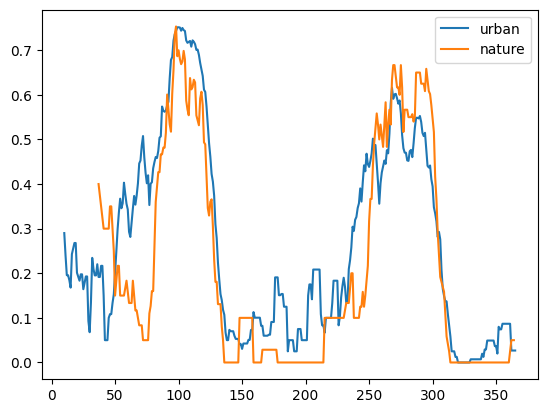

In [74]:
# plt.plot(passenger_df[['DOY','occ']].groupby('DOY').mean().rolling(10).mean())
plt.plot(passenger_df[passenger_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(passenger_df[passenger_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()



In [75]:
passenger_df

DOY  year  obsvr_species_count  longitude   latitude  urban_areas   
219487  103  2013                  229 -75.729563  45.376463     0.898507  \
219488   76  2013                  747 -75.758520  45.342093     0.777439   
219489  142  2013                  871 -76.084642  45.479352     0.000000   
219490  117  2013                 1059 -75.724081  45.394517     0.687500   
219491   90  2013                 1075 -75.491738  45.502978     0.281938   
...     ...   ...                  ...        ...        ...          ...   
224707  103  2018                 1462 -75.793224  45.366491     0.497396   
224708  109  2018                 1078 -75.618381  45.362278     0.527066   
224709   88  2018                 1078 -75.689855  45.383897     0.769231   
224710   79  2018                  405 -75.766331  45.350099     0.860158   
224711  104  2018                 1078 -75.618303  45.352308     0.375000   

        cropland  duration_minutes  occ          Order   
219487  0.005970              20.0    0  Passeriformes  \
219488  0.027439               5.0    0  Passeriformes   
219489  0.000000              10.0    0  Passeriformes   
219490  0.005952             210.0    0  Passeriformes   
219491  0.026432              70.0    0  Passeriformes   
...          ...               ...  ...            ...   
224707  0.000000              21.0    1  Passeriformes   
224708  0.051282              26.0    1  Passeriformes   
224709  0.005917              17.0    1  Passeriformes   
224710  0.002639              13.0    1  Passeriformes   
224711  0.072674              77.0    1  Passeriformes   

                            sp migration_type  record_index  year_index   
219487  Golden-crowned Kinglet      passenger             0           0  \
219488  Golden-crowned Kinglet      passenger             1           0   
219489  Golden-crowned Kinglet      passenger             2           0   
219490  Golden-crowned Kinglet      passenger             3           0   
219491  Golden-crowned Kinglet      passenger             4           0   
...                        ...            ...           ...         ...   
224707  Golden-crowned Kinglet      passenger          5220           5   
224708  Golden-crowned Kinglet      passenger          5221           5   
224709  Golden-crowned Kinglet      passenger          5222           5   
224710  Golden-crowned Kinglet      passenger          5223           5   
224711  Golden-crowned Kinglet      passenger          5224           5   

        order_index  sp_index  
219487            0         0  
219488            0         0  
219489            0         0  
219490            0         0  
219491            0         0  
...             ...       ...  
224707            0         0  
224708            0         0  
224709            0         0  
224710            0         0  
224711            0         0  

[5225 rows x 16 columns]

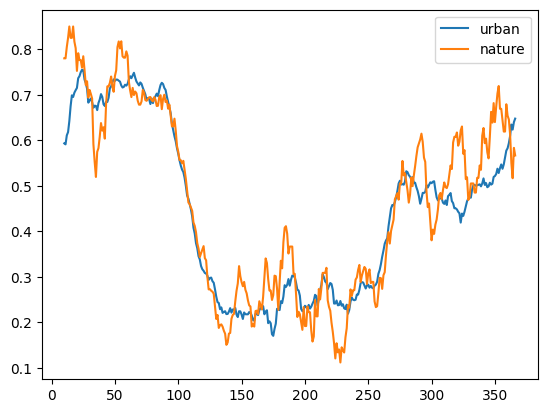

In [76]:

plt.plot(wintering_df[wintering_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(wintering_df[wintering_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()


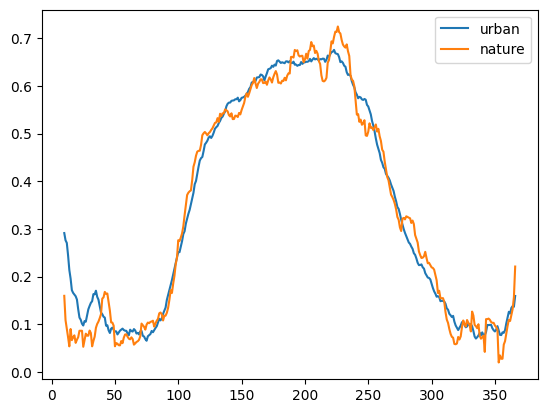

In [77]:

plt.plot(breeding_df[breeding_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(breeding_df[breeding_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()


# 5\. Spring departure model

## 5\.0 Train test split

In [78]:
from sklearn.model_selection import train_test_split
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for sp in wintering_df.sp.unique():
    sub = wintering_df[wintering_df.sp==sp]
    
    for year in sub.year.unique():
        try:
            subsub=sub[sub.year==year]
            
            X_train, X_test, y_train, y_test = train_test_split(subsub[[i for i in subsub.columns if not i=='occ']],
                                                                subsub['occ'],test_size=0.2)
            X_train_list.append(X_train)
            X_test_list.append(X_test)
            y_train_list.append(y_train)
            y_test_list.append(y_test)
        except Exception as e:
            print(e)
            continue
    
    
X_train = pd.concat(X_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

#### normalize
X_train_duration_minutes_std= X_train.duration_minutes.std()
X_train_duration_minutes_mean= X_train.duration_minutes.mean()
X_train_cropland_std= X_train.cropland.std()
X_train_cropland_mean= X_train.cropland.mean()
X_train_urban_areas_std= X_train.urban_areas.std()
X_train_urban_areas_mean= X_train.urban_areas.mean()

X_train['duration_minutes'] = (X_train['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_test['duration_minutes'] = (X_test['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_train['cropland'] = (X_train['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_test['cropland'] = (X_test['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_train['urban_areas'] = (X_train['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std
X_test['urban_areas'] = (X_test['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std



## 5\.1 Define model

In [79]:
### passenger model
def cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return 0.5 + 0.5 * pm.math.erf((x-mu)/(sigma*s))

### running

wintering_model = pm.Model()

with wintering_model:
    wintering_model.add_coord("record_index", sorted(wintering_df['record_index'].unique()))
    wintering_model.add_coord("sp_index", sorted(wintering_df['sp_index'].unique()))
    wintering_model.add_coord("year_index", sorted(wintering_df['year_index'].unique()))
    wintering_model.add_coord("order_index", sorted(wintering_df['order_index'].unique()))
    
    
    DOY_obs = pm.Data('DOY_obs',X_train.DOY.values)
    occ_obs = pm.Data('occ_obs',y_train.values)
    urban_areas_obs = pm.Data('urban_areas_obs',X_train.urban_areas.values)
    cropland_obs = pm.Data('cropland_obs',X_train.cropland.values)
    duration_obs = pm.Data('duration_obs',X_train.duration_minutes.values)
    
    sp_index_obs = pm.Data('sp_index_obs', X_train.sp_index.values)
    year_index_obs = pm.Data('year_index_obs', X_train.year_index.values)
    order_to_sp_obs = pm.Data('order_to_sp_obs', X_train[['sp_index','order_index']].drop_duplicates().sort_values(by='sp_index')['order_index'].values)
    
    ### prior
    ## spring departure
    spring_departure_dist_mu_overall = pm.TruncatedNormal('spring_departure_dist_mu_overall', mu=106, sigma=20, lower=0, upper=175)
    spring_departure_dist_mu = pm.TruncatedNormal('spring_departure_dist_mu', mu=spring_departure_dist_mu_overall, sigma=20, lower=0, upper=175, dims=('sp_index','year_index'))
    spring_departure_dist_sigma = pm.Gamma('spring_departure_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    ## fall arrival
    fall_arrival_dist_mu_overall = pm.TruncatedNormal('fall_arrival_dist_mu_overall', mu=291, sigma=20, lower=175, upper=366)
    fall_arrival_dist_mu = pm.TruncatedNormal('fall_arrival_dist_mu', mu=fall_arrival_dist_mu_overall, sigma=20, lower=175, upper=366, dims=('sp_index','year_index'))
    fall_arrival_dist_sigma = pm.Gamma('fall_arrival_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    ###
    simga_factor = 20
    effect_bound_fator = 60
    
    # #### urban effect   
    spring_departure_urban_effect_overall = pm.TruncatedNormal('spring_departure_urban_effect_overall', mu=0, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std)
    spring_departure_urban_effect_order_level = pm.TruncatedNormal('spring_departure_urban_effect_order_level', mu=spring_departure_urban_effect_overall, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('order_index'))
    spring_departure_urban_effect = pm.TruncatedNormal('spring_departure_urban_effect', mu=spring_departure_urban_effect_order_level[order_to_sp_obs], 
                                              sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('year_index','sp_index'))
    
    fall_arrival_urban_effect_overall = pm.TruncatedNormal('fall_arrival_urban_effect_overall', mu=0, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std)
    fall_arrival_urban_effect_order_level = pm.TruncatedNormal('fall_arrival_urban_effect_order_level', mu=fall_arrival_urban_effect_overall, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('order_index'))
    fall_arrival_urban_effect = pm.TruncatedNormal('fall_arrival_urban_effect', mu=fall_arrival_urban_effect_order_level[order_to_sp_obs],
                                          sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('year_index','sp_index'))

    
    #### cropland effect   
    spring_departure_cropland_effect_overall = pm.TruncatedNormal('spring_departure_cropland_effect_overall', mu=0, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std)
    spring_departure_cropland_effect_order_level = pm.TruncatedNormal('spring_departure_cropland_effect_order_level', mu=spring_departure_cropland_effect_overall, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('order_index'))
    spring_departure_cropland_effect = pm.TruncatedNormal('spring_departure_cropland_effect', mu=spring_departure_cropland_effect_order_level[order_to_sp_obs], 
                                                sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('year_index', 'sp_index'))
    
    fall_arrival_cropland_effect_overall = pm.TruncatedNormal('fall_arrival_cropland_effect_overall', mu=0, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std)
    fall_arrival_cropland_effect_order_level = pm.TruncatedNormal('fall_arrival_cropland_effect_order_level', mu=fall_arrival_cropland_effect_overall, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('order_index'))
    fall_arrival_cropland_effect = pm.TruncatedNormal('fall_arrival_cropland_effect', mu=fall_arrival_cropland_effect_order_level[order_to_sp_obs], 
                                            sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('year_index', 'sp_index'))
    
    ##### intercept
    beta = pm.Normal('beta', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    ### duration effect
    duration_effect_slope = pm.TruncatedNormal('duration_effect_slope', mu=0, sigma=10, lower=0, dims=('sp_index','year_index'))
    
    #### city effect modification on timing
    #####
    
    modified_spring_departure_dist = spring_departure_dist_mu[sp_index_obs, year_index_obs] + \
                                        (spring_departure_urban_effect[year_index_obs, sp_index_obs] * urban_areas_obs + \
                                            spring_departure_cropland_effect[year_index_obs, sp_index_obs] * cropland_obs)
    modified_fall_arrival_dist = fall_arrival_dist_mu[sp_index_obs, year_index_obs] + \
                                        (fall_arrival_urban_effect[year_index_obs, sp_index_obs] * urban_areas_obs + \
                                            fall_arrival_cropland_effect[year_index_obs, sp_index_obs] * cropland_obs)

    ### scaling factor
    w = pm.Dirichlet('w', a=np.ones([len(X_train.sp_index.unique()),
                                    len(X_train.year_index.unique()),
                                    2]))
    soft_diff_constraint_on_w = pm.Potential("soft_diff_constraint_on_w", -((pm.math.log(w[...,0]) - pm.math.log(w[...,1]))**2))
    
    ### variables times scalers
    spring_departure_effect_on_obs_prob = -(cumulative_normal(x=DOY_obs, 
                              mu=modified_spring_departure_dist, 
                              sigma=spring_departure_dist_sigma[sp_index_obs, year_index_obs])) * w[sp_index_obs, year_index_obs, 0]
 
        
    fall_arrival_effect_on_obs_prob =  (cumulative_normal(x=DOY_obs, 
                                                         mu=modified_fall_arrival_dist, 
                                                         sigma=fall_arrival_dist_sigma[sp_index_obs, year_index_obs]))* w[sp_index_obs, year_index_obs, 1]

    #### Effect of land use on detectability
    urban_effect_on_detectability_overall = pm.Normal('urban_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    cropland_effect_on_detectability_overall = pm.Normal('cropland_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    #### alpha
    alpha = pm.Lognormal('alpha', mu=2, sigma=1, dims=('sp_index','year_index'))
    
    #### linear term 
    y0 = beta[sp_index_obs, year_index_obs] + \
            duration_effect_slope[sp_index_obs, year_index_obs] * duration_obs + \
            urban_effect_on_detectability_overall[sp_index_obs, year_index_obs] * urban_areas_obs + \
            cropland_effect_on_detectability_overall[sp_index_obs, year_index_obs] * cropland_obs + \
            alpha[sp_index_obs, year_index_obs] * (spring_departure_effect_on_obs_prob + fall_arrival_effect_on_obs_prob)
            
    p_ = pm.math.sigmoid(y0)
    
    y_ = pm.Bernoulli("y_", p_, observed=occ_obs)
    

    

    

In [80]:
### prior predictives

with wintering_model:
    prior_pred = pm.sample_prior_predictive(1000)
    

Sampling: [alpha, beta, cropland_effect_on_detectability_overall, duration_effect_slope, fall_arrival_cropland_effect, fall_arrival_cropland_effect_order_level, fall_arrival_cropland_effect_overall, fall_arrival_dist_mu, fall_arrival_dist_mu_overall, fall_arrival_dist_sigma, fall_arrival_urban_effect, fall_arrival_urban_effect_order_level, fall_arrival_urban_effect_overall, spring_departure_cropland_effect, spring_departure_cropland_effect_order_level, spring_departure_cropland_effect_overall, spring_departure_dist_mu, spring_departure_dist_mu_overall, spring_departure_dist_sigma, spring_departure_urban_effect, spring_departure_urban_effect_order_level, spring_departure_urban_effect_overall, urban_effect_on_detectability_overall, w, y_]


<Axes: xlabel='DOY'>

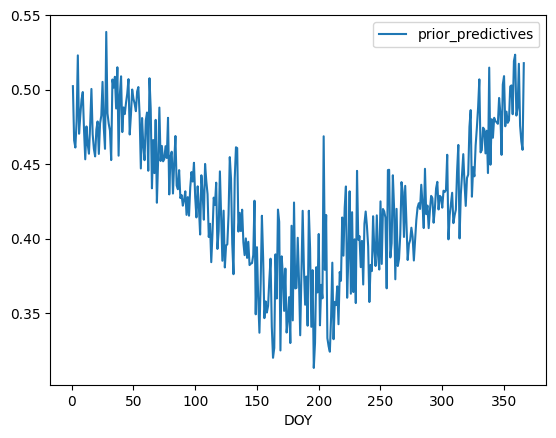

In [81]:
prior_p = np.concatenate(prior_pred.prior_predictive['y_'], axis=0).mean(axis=0)
pd.DataFrame({
    'DOY':X_train.DOY.values,
    'prior_predictives':prior_p
}).groupby('DOY').mean().plot()


## 5\.2 Sample chains

In [82]:
import pymc.sampling.jax as pmjax
import jax
import tensorflow_probability.substrates.jax as tfp
jax.scipy.special.erfcx = tfp.math.erfcx
from fastprogress.fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()

with wintering_model:
    idata = pmjax.sample_numpyro_nuts(SAMPLE_SIZE,chains=SAMPLE_CHAINS,cores=SAMPLE_CORES, tune=TUNES, progressbar=True)

    #  target_accept=0.99,
    #                   chains=2, cores=2, tune=3000, progressbar=True,
    #                     # trace = ['y_']
                      

Compiling...
Compilation time =  0:00:13.927882
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:09:21.992888
Transforming variables...
Transformation time =  0:00:00.827247


In [83]:
with wintering_model:
    post_idata = pm.sample_posterior_predictive(idata)

<Axes: xlabel='DOY'>

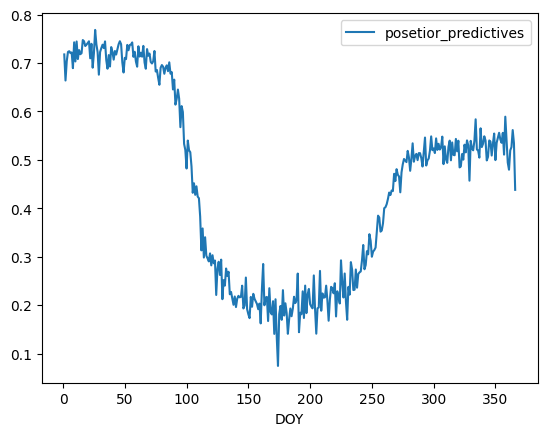

In [84]:
pd.DataFrame({
    'DOY':X_train.DOY.values,
    'posetior_predictives':np.concatenate(post_idata.posterior_predictive['y_'], axis=0).mean(axis=0)
}).groupby('DOY').mean().plot()


## 5\.3 Predict on test data

In [85]:
def pm_predict_winter_model(X_test):
    ### passenger model
    import math
    from scipy.special import expit
    def math_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return 0.5 + 0.5 * math.erf((x-mu)/(sigma*s))

    new_DOY_obs = X_test['DOY'].values
    new_sp_index_obs = X_test['sp_index'].values
    new_year_index_obs = X_test['year_index'].values
    new_urban_areas_obs = X_test['urban_areas'].values
    new_cropland_obs = X_test['cropland'].values
    new_duration_obs = X_test['duration_minutes'].values

    new_beta = np.concatenate(idata.posterior['beta'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_duration_effect_on_obs_prob = np.concatenate(idata.posterior['duration_effect_slope'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]

    new_modified_spring_departure_dist = np.concatenate(idata.posterior['spring_departure_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                            np.concatenate(idata.posterior['spring_departure_urban_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_urban_areas_obs + \
                                                np.concatenate(idata.posterior['spring_departure_cropland_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_cropland_obs
                                                
    new_spring_departure_effect_on_obs_prob =  (
        np.array([-math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
        new_DOY_obs,
        new_modified_spring_departure_dist, 
        np.concatenate(idata.posterior['spring_departure_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    )])) * np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 0]

    new_modified_fall_arrival_dist = np.concatenate(idata.posterior['fall_arrival_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                        np.concatenate(idata.posterior['fall_arrival_urban_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_urban_areas_obs + \
                                            np.concatenate(idata.posterior['fall_arrival_cropland_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_cropland_obs
                                            
    new_fall_arrival_effect_on_obs_prob = (np.array([
        math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
            new_DOY_obs,
            new_modified_fall_arrival_dist,
            np.concatenate(idata.posterior['fall_arrival_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
        )
    ]))* np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 1]

    new_alpha = np.concatenate(idata.posterior['alpha'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_urban_effect_on_detectability_overall = np.concatenate(idata.posterior['urban_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_cropland_effect_on_detectability_overall = np.concatenate(idata.posterior['cropland_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_y0 = new_beta + \
            new_duration_effect_on_obs_prob * new_duration_obs + \
            new_urban_effect_on_detectability_overall * new_urban_areas_obs + \
            new_cropland_effect_on_detectability_overall * new_cropland_obs + \
            new_alpha * (new_spring_departure_effect_on_obs_prob + new_fall_arrival_effect_on_obs_prob)
            
    new_p_ = expit(new_y0)
    y_pred = np.where(new_p_>0.5,1,0)
    return y_pred




In [86]:
y_pred = pm_predict_winter_model(X_test)

In [87]:
post_bi = np.where(
    np.concatenate(post_idata.posterior_predictive['y_'].values, axis=0).mean(axis=0)>0.5,
    1,0
)


In [88]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

print(
    roc_auc_score(y_train, post_bi), precision_score(y_train, post_bi), recall_score(y_train, post_bi), f1_score(y_train, post_bi)
)

print(
    roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
)


0.697520941506691 0.6560725610205737 0.7502318913905051 0.6999999999999998
0.6902681483712023 0.6462209302325581 0.748989218328841 0.6938202247191011


## 5\.4 Evaluate and save data

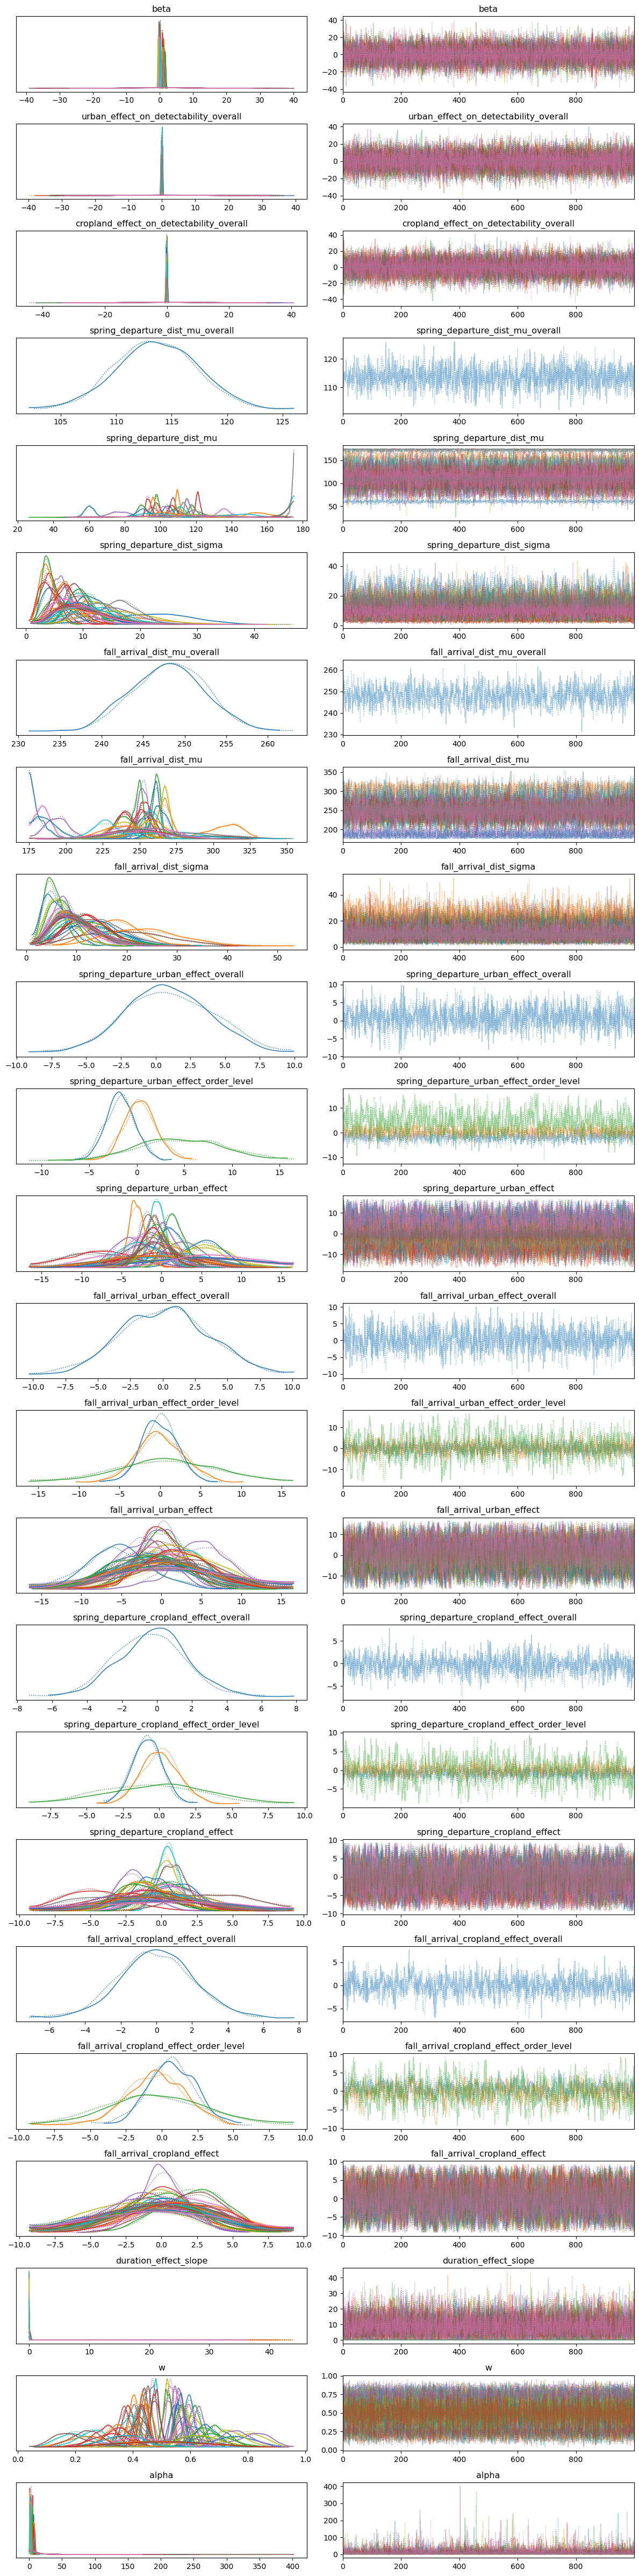

In [89]:
az.rcParams["plot.max_subplots"] = 50
az.plot_trace(idata)
plt.tight_layout()
plt.show()


In [90]:
###
ess_ = az.ess(idata)
rhat_ = az.rhat(idata)
bfmi_ = az.bfmi(idata)
    
### save data
with open(f'{wintering_prefix}.pkl','wb') as f:
    pickle.dump({'idata':idata,'post_data':post_idata, ### trace and posterior predictives
                 'ess':ess_,'rhat':rhat_,'bmfi':bfmi_, ### evaluations
                 'train_roc_auc':roc_auc_score(y_train, post_bi),
                 'train_precision':precision_score(y_train, post_bi), 
                 'train_recall':recall_score(y_train, post_bi), 
                 'train_f1':f1_score(y_train, post_bi),
                 
                 'test_roc_auc':roc_auc_score(y_test, y_pred),
                 'test_precision':precision_score(y_test, y_pred), 
                 'test_recall':recall_score(y_test, y_pred), 
                 'test_f1':f1_score(y_test, y_pred),
                 
                 'X_train_duration_minutes_std':X_train_duration_minutes_std,
                 'X_train_duration_minutes_mean':X_train_duration_minutes_mean,
                 'X_train_cropland_std':X_train_cropland_std,
                 'X_train_cropland_mean':X_train_cropland_mean,
                 'X_train_urban_areas_std':X_train_urban_areas_std,
                 'X_train_urban_areas_mean':X_train_urban_areas_mean
                 }, f)



In [91]:
rhat_

<xarray.Dataset>
Dimensions:                                       (sp_index: 6, year_index: 8,
                                                   order_index: 3, w_dim_0: 6,
                                                   w_dim_1: 8, w_dim_2: 2)
Coordinates:
  * sp_index                                      (sp_index) int64 0 1 2 3 4 5
  * year_index                                    (year_index) int64 0 1 ... 6 7
  * order_index                                   (order_index) int64 0 1 2
  * w_dim_0                                       (w_dim_0) int64 0 1 2 3 4 5
  * w_dim_1                                       (w_dim_1) int64 0 1 2 ... 6 7
  * w_dim_2                                       (w_dim_2) int64 0 1
Data variables: (12/24)
    beta                                          (sp_index, year_index) float64 ...
    urban_effect_on_detectability_overall         (sp_index, year_index) float64 ...
    cropland_effect_on_detectability_overall      (sp_index, year_index) float64 ...
    spring_departure_dist_mu_overall              float64 1.004
    spring_departure_dist_mu                      (sp_index, year_index) float64 ...
    spring_departure_dist_sigma                   (sp_index, year_index) float64 ...
    ...                                            ...
    fall_arrival_cropland_effect_overall          float64 1.005
    fall_arrival_cropland_effect_order_level      (order_index) float64 1.003...
    fall_arrival_cropland_effect                  (year_index, sp_index) float64 ...
    duration_effect_slope                         (sp_index, year_index) float64 ...
    w                                             (w_dim_0, w_dim_1, w_dim_2) float64 ...
    alpha                                         (sp_index, year_index) float64 ...

In [92]:
bfmi_

array([0.87821626, 0.90724948])

# 6\. Fall departure model

## 6\.0 Train test split

In [93]:
from sklearn.model_selection import train_test_split
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for sp in breeding_df.sp.unique():
    sub = breeding_df[breeding_df.sp==sp]
    
    for year in sub.year.unique():
        subsub=sub[sub.year==year]
        
        X_train, X_test, y_train, y_test = train_test_split(subsub[[i for i in subsub.columns if not i=='occ']],
                                                            subsub['occ'],test_size=0.2)
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)
    
    
X_train = pd.concat(X_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

#### normalize
X_train_duration_minutes_std= X_train.duration_minutes.std()
X_train_duration_minutes_mean= X_train.duration_minutes.mean()
X_train_cropland_std= X_train.cropland.std()
X_train_cropland_mean= X_train.cropland.mean()
X_train_urban_areas_std= X_train.urban_areas.std()
X_train_urban_areas_mean= X_train.urban_areas.mean()

X_train['duration_minutes'] = (X_train['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_test['duration_minutes'] = (X_test['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_train['cropland'] = (X_train['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_test['cropland'] = (X_test['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_train['urban_areas'] = (X_train['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std
X_test['urban_areas'] = (X_test['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std



## 6\.1 Define model

In [94]:
### passenger model
def cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return 0.5 + 0.5 * pm.math.erf((x-mu)/(sigma*s))

### running

breeding_model = pm.Model()

with breeding_model:
    breeding_model.add_coord("record_index", sorted(breeding_df['record_index'].unique()))
    breeding_model.add_coord("sp_index", sorted(breeding_df['sp_index'].unique()))
    breeding_model.add_coord("year_index", sorted(breeding_df['year_index'].unique()))
    breeding_model.add_coord("order_index", sorted(breeding_df['order_index'].unique()))
    
    
    DOY_obs = pm.Data('DOY_obs',X_train.DOY.values)
    occ_obs = pm.Data('occ_obs',y_train.values)
    urban_areas_obs = pm.Data('urban_areas_obs',X_train.urban_areas.values)
    cropland_obs = pm.Data('cropland_obs',X_train.cropland.values)
    duration_obs = pm.Data('duration_obs',X_train.duration_minutes.values)
    
    sp_index_obs = pm.Data('sp_index_obs', X_train.sp_index.values)
    year_index_obs = pm.Data('year_index_obs', X_train.year_index.values)
    order_to_sp_obs = pm.Data('order_to_sp_obs', X_train[['sp_index','order_index']].drop_duplicates().sort_values(by='sp_index')['order_index'].values)
    
    ### prior
    ## spring departure
    spring_arrival_dist_mu_overall = pm.TruncatedNormal('spring_arrival_dist_mu_overall', mu=106, sigma=20, lower=0, upper=175)
    spring_arrival_dist_mu = pm.TruncatedNormal('spring_arrival_dist_mu', mu=spring_arrival_dist_mu_overall, sigma=20, lower=0, upper=175, dims=('sp_index','year_index'))
    spring_arrival_dist_sigma = pm.Gamma('spring_arrival_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    ## fall arrival
    fall_departure_dist_mu_overall = pm.TruncatedNormal('fall_departure_dist_mu_overall', mu=291, sigma=20, lower=175, upper=366)
    fall_departure_dist_mu = pm.TruncatedNormal('fall_departure_dist_mu', mu=fall_departure_dist_mu_overall, sigma=20, lower=175, upper=366, dims=('sp_index','year_index'))
    fall_departure_dist_sigma = pm.Gamma('fall_departure_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    ###
    simga_factor = 20
    effect_bound_fator = 60
    
    # #### urban effect   
    spring_arrival_urban_effect_overall = pm.TruncatedNormal('spring_arrival_urban_effect_overall', mu=0, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std)
    spring_arrival_urban_effect_order_level = pm.TruncatedNormal('spring_arrival_urban_effect_order_level', mu=spring_arrival_urban_effect_overall, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('order_index'))
    spring_arrival_urban_effect = pm.TruncatedNormal('spring_arrival_urban_effect', mu=spring_arrival_urban_effect_order_level[order_to_sp_obs], 
                                            sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('year_index', 'sp_index'))
    fall_departure_urban_effect_overall = pm.TruncatedNormal('fall_departure_urban_effect_overall', mu=0, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std)
    fall_departure_urban_effect_order_level = pm.TruncatedNormal('fall_departure_urban_effect_order_level', mu=fall_departure_urban_effect_overall, sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('order_index'))
    fall_departure_urban_effect = pm.TruncatedNormal('fall_departure_urban_effect', mu=fall_departure_urban_effect_order_level[order_to_sp_obs],
                                       sigma=simga_factor*X_train_urban_areas_std, upper=effect_bound_fator*X_train_urban_areas_std, lower=-effect_bound_fator*X_train_urban_areas_std, dims=('year_index','sp_index'))
    
    #### cropland effect   
    spring_arrival_cropland_effect_overall = pm.TruncatedNormal('spring_arrival_cropland_effect_overall', mu=0, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std)
    spring_arrival_cropland_effect_order_level = pm.TruncatedNormal('spring_arrival_cropland_effect_order_level', mu=spring_arrival_cropland_effect_overall, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('order_index'))
    spring_arrival_cropland_effect = pm.TruncatedNormal('spring_arrival_cropland_effect', mu=spring_arrival_cropland_effect_order_level[order_to_sp_obs], 
                                                sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('year_index', 'sp_index'))
    fall_departure_cropland_effect_overall = pm.TruncatedNormal('fall_departure_cropland_effect_overall', mu=0, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std)
    fall_departure_cropland_effect_order_level = pm.TruncatedNormal('fall_departure_cropland_effect_order_level', mu=fall_departure_cropland_effect_overall, sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('order_index'))
    fall_departure_cropland_effect = pm.TruncatedNormal('fall_departure_cropland_effect', mu=fall_departure_cropland_effect_order_level[order_to_sp_obs], 
                                            sigma=simga_factor*X_train_cropland_std, upper=effect_bound_fator*X_train_cropland_std, lower=-effect_bound_fator*X_train_cropland_std, dims=('year_index','sp_index'))
    
    ##### intercept
    beta = pm.Normal('beta', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    ### duration effect
    duration_effect_slope = pm.TruncatedNormal('duration_effect_slope', mu=0, sigma=10, lower=0, dims=('sp_index','year_index'))
    
    #### city effect modification on timing
    #####
    
    modified_spring_arrival_dist = spring_arrival_dist_mu[sp_index_obs, year_index_obs] + \
                                        (spring_arrival_urban_effect[year_index_obs, sp_index_obs] * urban_areas_obs + \
                                            spring_arrival_cropland_effect[year_index_obs, sp_index_obs] * cropland_obs)
    modified_fall_departure_dist = fall_departure_dist_mu[sp_index_obs, year_index_obs] + \
                                        (fall_departure_urban_effect[year_index_obs, sp_index_obs] * urban_areas_obs + \
                                            fall_departure_cropland_effect[year_index_obs, sp_index_obs] * cropland_obs)

    ### scaling factor
    w = pm.Dirichlet('w', a=np.ones([len(X_train.sp_index.unique()),
                                    len(X_train.year_index.unique()),
                                    2]))
    soft_diff_constraint_on_w = pm.Potential("soft_diff_constraint_on_w", -((pm.math.log(w[...,0]) - pm.math.log(w[...,1]))**2))

    ### variables times scalers
    spring_arrival_effect_on_obs_prob = (cumulative_normal(x=DOY_obs, 
                              mu=modified_spring_arrival_dist, 
                              sigma=spring_arrival_dist_sigma[sp_index_obs, year_index_obs])) * w[sp_index_obs, year_index_obs, 0]
 
        
    fall_departure_effect_on_obs_prob =  -(cumulative_normal(x=DOY_obs, 
                                                         mu=modified_fall_departure_dist, 
                                                         sigma=fall_departure_dist_sigma[sp_index_obs, year_index_obs]))* w[sp_index_obs, year_index_obs, 1]

    #### Effect of land use on detectability
    urban_effect_on_detectability_overall = pm.Normal('urban_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    cropland_effect_on_detectability_overall = pm.Normal('cropland_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    #### alpha
    alpha = pm.Lognormal('alpha', mu=2, sigma=1, dims=('sp_index','year_index'))
    
    #### linear term 
    y0 = beta[sp_index_obs, year_index_obs] + \
            duration_effect_slope[sp_index_obs,year_index_obs] * duration_obs + \
            urban_effect_on_detectability_overall[sp_index_obs, year_index_obs] * urban_areas_obs + \
            cropland_effect_on_detectability_overall[sp_index_obs, year_index_obs] * cropland_obs + \
            alpha[sp_index_obs, year_index_obs] * (spring_arrival_effect_on_obs_prob + fall_departure_effect_on_obs_prob)
            
    p_ = pm.math.sigmoid(y0)
    
    y_ = pm.Bernoulli("y_", p_, observed=occ_obs)
    

    

## 6\.2 Sample chains

In [95]:
import pymc.sampling.jax as pmjax
import jax
import tensorflow_probability.substrates.jax as tfp
jax.scipy.special.erfcx = tfp.math.erfcx
from fastprogress.fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()

with breeding_model:
    idata = pmjax.sample_numpyro_nuts(SAMPLE_SIZE,chains=SAMPLE_CHAINS,cores=SAMPLE_CORES, tune=TUNES, progressbar=True)
    
    #  target_accept=0.99,
    #                   chains=2, cores=2, tune=3000, progressbar=True,
    #                     # trace = ['y_']
                      

Compiling...
Compilation time =  0:00:15.539386
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
with breeding_model:
    post_idata = pm.sample_posterior_predictive(idata)

<Axes: xlabel='DOY'>

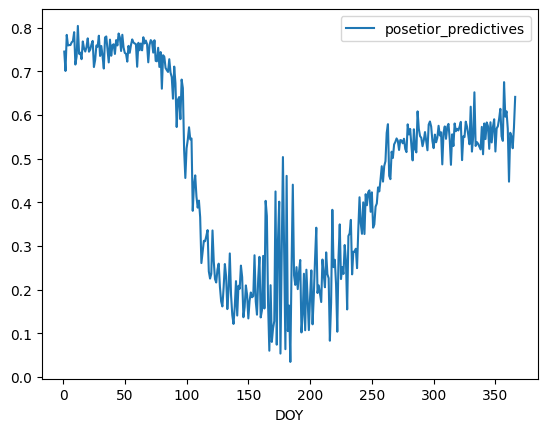

In [ ]:
pd.DataFrame({
    'DOY':X_train.DOY.values,
    'posetior_predictives':np.concatenate(post_idata.posterior_predictive['y_'], axis=0).mean(axis=0)
}).groupby('DOY').mean().plot()


## 6\.3 Predict on test data

In [ ]:
def pm_predict_breeding_model(X_test):
    ### passenger model
    import math
    from scipy.special import expit
    def math_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return 0.5 + 0.5 * math.erf((x-mu)/(sigma*s))

    new_DOY_obs = X_test['DOY'].values
    new_sp_index_obs = X_test['sp_index'].values
    new_year_index_obs = X_test['year_index'].values
    new_urban_areas_obs = X_test['urban_areas'].values
    new_cropland_obs = X_test['cropland'].values
    new_duration_obs = X_test['duration_minutes'].values

    new_beta = np.concatenate(idata.posterior['beta'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_duration_effect_on_obs_prob = np.concatenate(idata.posterior['duration_effect_slope'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]

    new_modified_spring_arrival_dist = np.concatenate(idata.posterior['spring_arrival_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                            np.concatenate(idata.posterior['spring_arrival_urban_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_urban_areas_obs + \
                                                np.concatenate(idata.posterior['spring_arrival_cropland_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_cropland_obs
                                                
    new_spring_arrival_effect_on_obs_prob =  (
        np.array([math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
        new_DOY_obs,
        new_modified_spring_arrival_dist, 
        np.concatenate(idata.posterior['spring_arrival_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    )])) * np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 0]

    new_modified_fall_departure_dist = np.concatenate(idata.posterior['fall_departure_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                        np.concatenate(idata.posterior['fall_departure_urban_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_urban_areas_obs + \
                                            np.concatenate(idata.posterior['fall_departure_cropland_effect'], axis=0).mean(axis=0)[new_year_index_obs, new_sp_index_obs] * new_cropland_obs
                                            
    new_fall_departure_effect_on_obs_prob = (np.array([
        -math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
            new_DOY_obs,
            new_modified_fall_departure_dist,
            np.concatenate(idata.posterior['fall_departure_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
        )
    ]))* np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 1]

    new_alpha = np.concatenate(idata.posterior['alpha'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_urban_effect_on_detectability_overall = np.concatenate(idata.posterior['urban_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_cropland_effect_on_detectability_overall = np.concatenate(idata.posterior['cropland_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_y0 = new_beta + \
            new_duration_effect_on_obs_prob * new_duration_obs + \
            new_urban_effect_on_detectability_overall * new_urban_areas_obs + \
            new_cropland_effect_on_detectability_overall * new_cropland_obs + \
            new_alpha * (new_spring_arrival_effect_on_obs_prob + new_fall_departure_effect_on_obs_prob)
            
    new_p_ = expit(new_y0)
    y_pred = np.where(new_p_>0.5,1,0)
    return y_pred





In [ ]:
y_pred = pm_predict_breeding_model(X_test)

In [ ]:
post_bi = np.where(
    np.concatenate(post_idata.posterior_predictive['y_'].values, axis=0).mean(axis=0)>0.5,
    1,0
)


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

print(
    roc_auc_score(y_train, post_bi), precision_score(y_train, post_bi), recall_score(y_train, post_bi), f1_score(y_train, post_bi)
)

print(
    roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
)


0.7506726047077877 0.7062264150943396 0.855934141321747 0.773906750749509
0.7326820049369971 0.6945481702763256 0.8416289592760181 0.7610474631751227


## 6\.4 Evaluate and save data

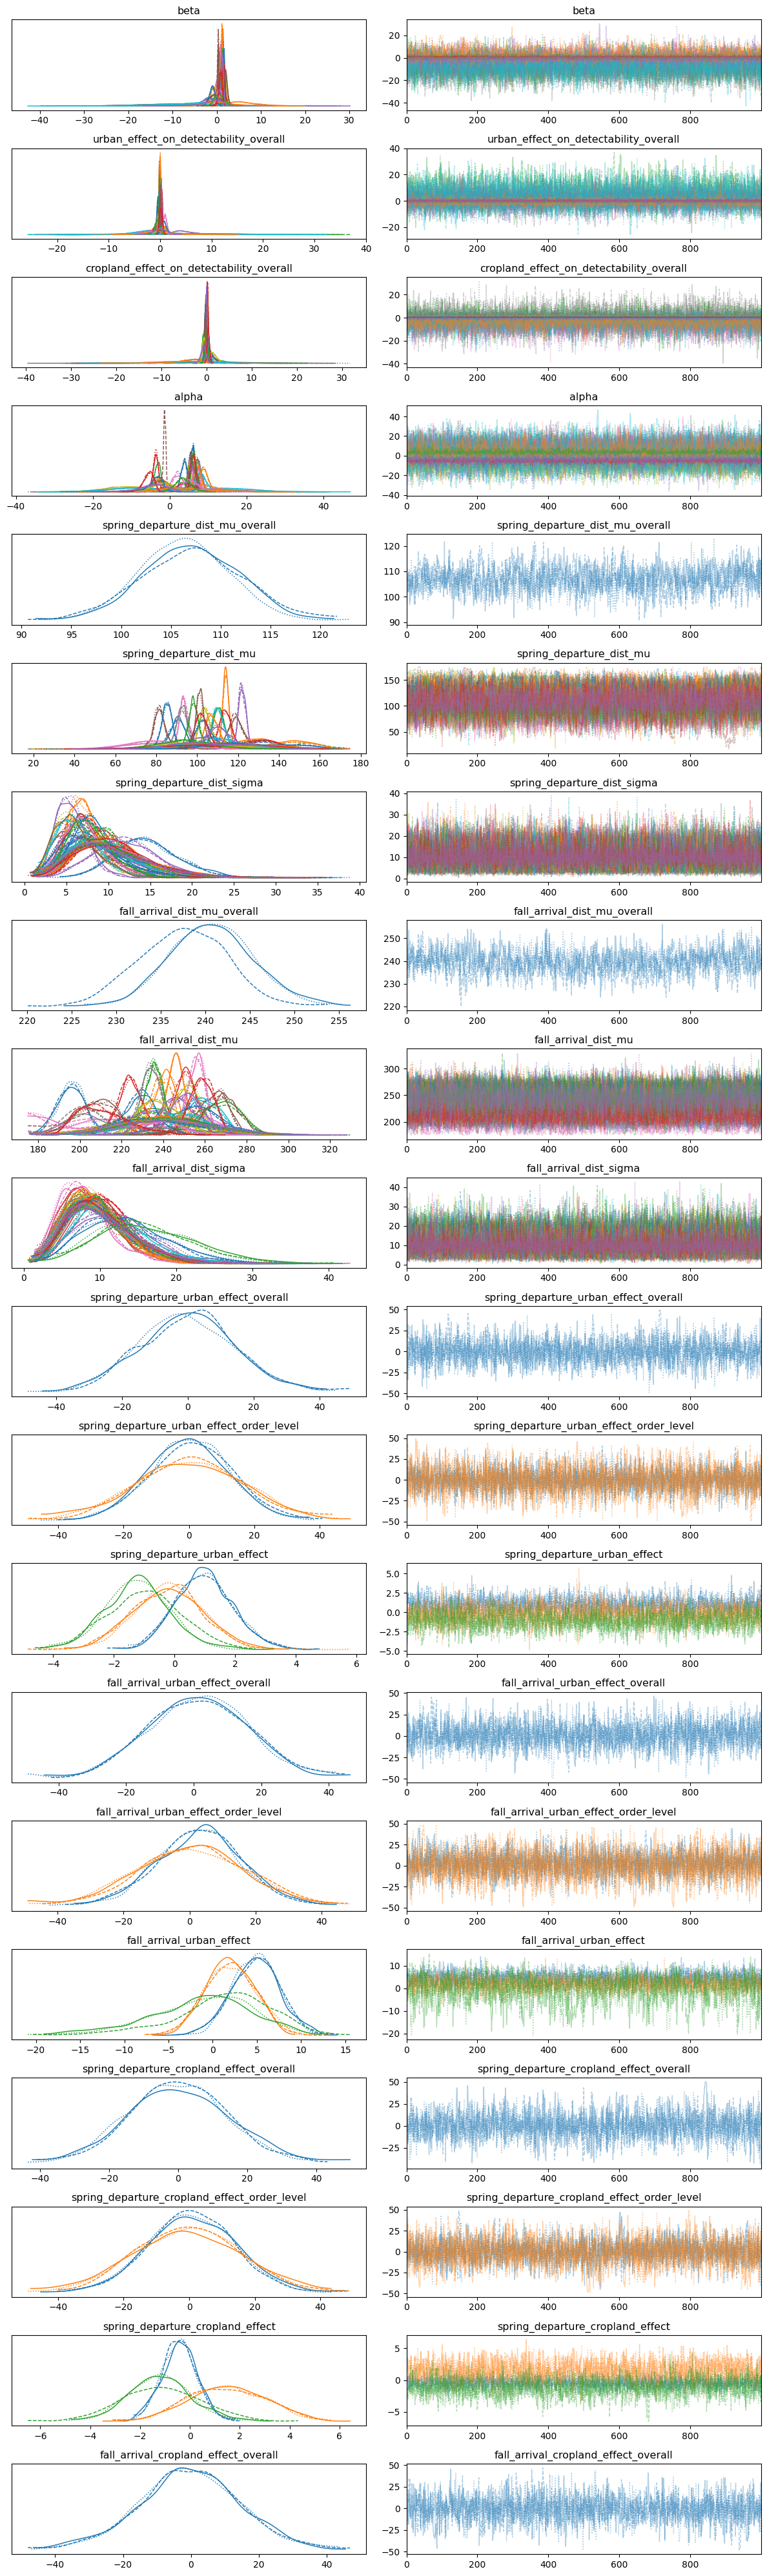

In [ ]:
az.rcParams["plot.max_subplots"] = 50
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [ ]:
###
ess_ = az.ess(idata)
rhat_ = az.rhat(idata)
bfmi_ = az.bfmi(idata)
    
### save data
with open(f'{breeding_prefix}.pkl','wb') as f:
    pickle.dump({'idata':idata,'post_data':post_idata, ### trace and posterior predictives
                 'ess':ess_,'rhat':rhat_,'bmfi':bfmi_, ### evaluations
                 'train_roc_auc':roc_auc_score(y_train, post_bi),
                 'train_precision':precision_score(y_train, post_bi), 
                 'train_recall':recall_score(y_train, post_bi), 
                 'train_f1':f1_score(y_train, post_bi),
                 
                 'test_roc_auc':roc_auc_score(y_test, y_pred),
                 'test_precision':precision_score(y_test, y_pred), 
                 'test_recall':recall_score(y_test, y_pred), 
                 'test_f1':f1_score(y_test, y_pred),
                 
                 'X_train_duration_minutes_std':X_train_duration_minutes_std,
                 'X_train_duration_minutes_mean':X_train_duration_minutes_mean,
                 'X_train_cropland_std':X_train_cropland_std,
                 'X_train_cropland_mean':X_train_cropland_mean,
                 'X_train_urban_areas_std':X_train_urban_areas_std,
                 'X_train_urban_areas_mean':X_train_urban_areas_mean
                 }, f)



In [ ]:
rhat_

<xarray.Dataset>
Dimensions:                                       (sp_index: 3, year_index: 15,
                                                   order_index: 2, w_dim_0: 3,
                                                   w_dim_1: 15, w_dim_2: 2)
Coordinates:
  * sp_index                                      (sp_index) int64 0 1 2
  * year_index                                    (year_index) int64 0 1 ... 14
  * order_index                                   (order_index) int64 0 1
  * w_dim_0                                       (w_dim_0) int64 0 1 2
  * w_dim_1                                       (w_dim_1) int64 0 1 ... 13 14
  * w_dim_2                                       (w_dim_2) int64 0 1
Data variables: (12/24)
    beta                                          (sp_index, year_index) float64 ...
    urban_effect_on_detectability_overall         (sp_index, year_index) float64 ...
    cropland_effect_on_detectability_overall      (sp_index, year_index) float64 ...
    alpha                                         (sp_index, year_index) float64 ...
    spring_departure_dist_mu_overall              float64 1.023
    spring_departure_dist_mu                      (sp_index, year_index) float64 ...
    ...                                            ...
    spring_departure_cropland_effect              (sp_index) float64 1.002 .....
    fall_arrival_cropland_effect_overall          float64 1.0
    fall_arrival_cropland_effect_order_level      (order_index) float64 1.001...
    fall_arrival_cropland_effect                  (sp_index) float64 1.001 .....
    duration_effect_slope                         (sp_index) float64 1.002 .....
    w                                             (w_dim_0, w_dim_1, w_dim_2) float64 ...

In [ ]:
bfmi_

array([0.82503237, 0.9409618 , 0.88500357])